<a href="https://colab.research.google.com/github/banupriyaprathaban/ESCGT/blob/ESCGT/ESCGT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install mne mne-bids

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 67.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.8/166.8 kB 12.1 MB/s eta 0:00:00


In [ ]:
!pip install -q mne mne-bids pandas numpy

In [ ]:
import os

ROOT = "./data"
paths = [
    f"{ROOT}/raw/openneuro-ds002424",
    f"{ROOT}/raw/tuh_eeg",
    f"{ROOT}/raw/ieee_dataport",
    f"{ROOT}/raw/srm_mch",
]

for p in paths:
    os.makedirs(p, exist_ok=True)


In [ ]:
import os, re, csv, glob, pathlib
from pathlib import Path
import numpy as np
import pandas as pd
import mne

# ---------- CONFIG ----------
ROOT = "/content/data"
EPOCH_LEN = 2.0
EPOCH_OVERLAP = 0.5
NOTCH_FREQ = 50.0
N_JOBS = 2
RANDOM_SEED = 23
TARGET_SFREQ = 256.0
BANDPASS = (0.5, 40.0)

DATASETS = {
    "OPENNEURO_DS002424": "raw/openneuro-ds002424",
    "TUH_EEG": "raw/tuh_eeg",
    "IEEE_DATAPORT": "raw/ieee_dataport",
    "SRM_MCH": "raw/srm_mch",
}

STANDARD_19 = ["Fp1","Fp2","F7","F3","Fz","F4","F8","T3","C3","Cz","C4","T4","T5","P3","Pz","P4","T6","O1","O2"]

CANONICAL_RENAMES = {"FP1":"Fp1","FP2":"Fp2","FZ":"Fz","CZ":"Cz","PZ":"Pz","O1":"O1","O2":"O2","A1":"T3","A2":"T4"}
LABEL_MAP = {"ADHD":1,"ADHD-1":1,"ADHD-2":1,"CONTROL":0,"NORMAL":0,"HEALTHY":0,"CONTROLLED":0,"CN":0}


def ensure_dirs():
    os.makedirs(ROOT, exist_ok=True)
    os.makedirs(os.path.join(ROOT, "manifests"), exist_ok=True)
    os.makedirs(os.path.join(ROOT, "preprocessing"), exist_ok=True)
    for _, rel in DATASETS.items():
        os.makedirs(os.path.join(ROOT, rel), exist_ok=True)

def guess_label_from_name(path: str) -> str:
    n = os.path.basename(path).lower()
    if "adhd" in n: return "ADHD"
    if re.search(r"(control|normal|hc|ctr|cn)", n): return "CONTROL"
    return "CONTROL"

def build_manifest_for(root: str, dataset_code: str, outfile: str):
    paths = []
    for ext in ("*.edf","*.bdf","*.gdf","*.fif","*.set","*.vhdr"):
        paths += glob.glob(os.path.join(root, "**", ext), recursive=True)
    with open(outfile, "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(["filepath","subject_id","label","dataset"])
        for p in sorted(paths):
            sid = pathlib.Path(p).stem[:32].upper()
            lbl = guess_label_from_name(p)
            w.writerow([os.path.abspath(p), sid, lbl, dataset_code])

def generate_manifests():
    manif_dir = os.path.join(ROOT, "manifests")
    for code, rel in DATASETS.items():
        src = os.path.join(ROOT, rel)
        out = os.path.join(manif_dir, f"{code.lower()}.csv")
        build_manifest_for(src, code, out)
    print("Manifests created in:", manif_dir)

def load_manifests() -> pd.DataFrame:
    csvs = sorted(glob.glob(os.path.join(ROOT, "manifests", "*.csv")))
    frames = []
    for c in csvs:
        df = pd.read_csv(c)
        if not set(["filepath","subject_id","label","dataset"]).issubset(df.columns):
            raise ValueError(f"Manifest {c} missing required columns")
        frames.append(df)
    if not frames:
        raise FileNotFoundError("No manifests found—did you put files in raw/ folders?")
    return pd.concat(frames, ignore_index=True)

def normalize_label(lbl: str) -> int:
    key = str(lbl).strip().upper()
    if key in LABEL_MAP: return LABEL_MAP[key]
    if key.startswith("CTRL"): return 0
    return 1 if "ADHD" in key else 0

def clean_ch_names(raw: mne.io.BaseRaw) -> None:
    new_names = {}
    for ch in raw.ch_names:
        c = ch.strip().replace(" ","").replace("-","")
        if c.upper() in CANONICAL_RENAMES:
            new_names[ch] = CANONICAL_RENAMES[c.upper()]
            continue
        c2 = c.replace("FP","Fp").replace("FZ","Fz").replace("CZ","Cz").replace("PZ","Pz")
        if len(c2) >= 2 and c2[0].isalpha():
            c2 = c2[0].upper() + c2[1:]
        new_names[ch] = c2
    raw.rename_channels(new_names)

def ensure_montage(raw: mne.io.BaseRaw):
    try:
        montage = mne.channels.make_standard_montage("standard_1020")
        raw.set_montage(montage, on_missing="ignore")
    except Exception as e:
        print("Montage warn:", e)

def pick_or_project_19(raw: mne.io.BaseRaw) -> mne.io.BaseRaw:
    present = [ch for ch in STANDARD_19 if ch in raw.ch_names]
    if len(present) == 19:
        return raw.pick(STANDARD_19, allow_empty=False).copy()
    raw2 = raw.copy()
    try:
        if raw2.get_montage() is not None and len(present) >= 12:
            raw2.info["bads"] = [ch for ch in STANDARD_19 if ch in raw2.info["ch_names"] and ch not in present]
            raw2.interpolate_bads(reset_bads=True, verbose=False)
    except Exception as e:
        print("Interpolation warn:", e)
    picks = [ch for ch in STANDARD_19 if ch in raw2.ch_names]
    return raw2.pick(picks).copy()

def run_ica(raw: mne.io.BaseRaw, random_state: int = RANDOM_SEED) -> mne.io.BaseRaw:
    n_components = min(15, len(raw.ch_names))
    ica = mne.preprocessing.ICA(n_components=n_components, random_state=random_state, method="fastica")
    with mne.utils.use_log_level("WARNING"):
        ica.fit(raw, picks="eeg", reject_by_annotation=True)
    eog_inds = []
    for eog_ch in ["EOG","VEOG","HEOG"]:
        if eog_ch in raw.ch_names:
            inds, _ = ica.find_bads_eog(raw, ch_name=eog_ch)
            eog_inds.extend(inds)
    if not eog_inds:
        eog_inds = list(range(min(2, n_components)))
    ica.exclude = sorted(set(eog_inds))
    return ica.apply(raw.copy())

def epoch_raw(raw: mne.io.BaseRaw, length_s: float, overlap: float) -> np.ndarray:
    step = max(1e-6, length_s*(1.0-overlap))
    sf = raw.info["sfreq"]
    win = int(round(length_s*sf))
    hop = max(1, int(round(step*sf)))
    data = raw.get_data(picks="eeg")
    n_times = data.shape[1]
    epochs = []
    for start in range(0, n_times - win + 1, hop):
        seg = data[:, start:start+win]
        if seg.shape[1] < win or np.any(np.isnan(seg)): continue
        mu = seg.mean(axis=1, keepdims=True)
        sd = seg.std(axis=1, keepdims=True) + 1e-8
        seg = (seg - mu) / sd
        epochs.append(seg.astype(np.float32))
    if not epochs:
        return np.zeros((0, len(raw.ch_names), win), dtype=np.float32)
    return np.stack(epochs, axis=0)

def read_raw_any(fp: str) -> mne.io.BaseRaw:
    ext = fp.lower().split(".")[-1]
    if ext in ("edf","bdf","gdf"):
        return mne.io.read_raw_edf(fp, preload=True, verbose=False)
    if ext in ("fif",):
        return mne.io.read_raw_fif(fp, preload=True, verbose=False)
    if ext in ("set",):
        return mne.io.read_raw_eeglab(fp, preload=True, verbose=False)
    if ext in ("vhdr",):
        return mne.io.read_raw_brainvision(fp, preload=True, verbose=False)
    return mne.io.read_raw(fp, preload=True, verbose=False)

def preprocess_file(filepath, subject_id, label_str, dataset, out_root):
    label = normalize_label(label_str)
    raw = read_raw_any(filepath)
    clean_ch_names(raw)
    ensure_montage(raw)
    raw.pick_types(eeg=True, eog=True, stim=False, meg=False)
    raw.load_data()

    raw.filter(BANDPASS[0], BANDPASS[1], picks="eeg", n_jobs=N_JOBS, verbose=False)
    if NOTCH_FREQ is not None:
        raw.notch_filter(freqs=[NOTCH_FREQ], picks="eeg", n_jobs=N_JOBS, verbose=False)

    if abs(raw.info["sfreq"] - TARGET_SFREQ) > 1e-6:
        raw.resample(sfreq=TARGET_SFREQ, npad="auto", verbose=False)

    raw = pick_or_project_19(raw)

    try:
        if raw.n_times / raw.info["sfreq"] >= 60.0:
            raw = run_ica(raw)
    except Exception as e:
        print("ICA warn:", e)

    try:
        raw.set_eeg_reference("average", projection=False, verbose=False)
    except Exception as e:
        print("CAR warn:", e)

    X = epoch_raw(raw, EPOCH_LEN, EPOCH_OVERLAP)

    out_dir = Path(os.path.join(ROOT, "preprocessing")) / dataset
    out_dir.mkdir(parents=True, exist_ok=True)
    out_npz = str(out_dir / f"{subject_id}.npz")
    np.savez_compressed(out_npz, x=X, y=np.int64(label))

    n_epochs = int(X.shape[0])
    n_channels = int(X.shape[1]) if n_epochs > 0 else len(raw.ch_names)
    return out_npz, n_epochs, n_channels, int(label)


np.random.seed(RANDOM_SEED)
ensure_dirs()
generate_manifests()
df = load_manifests()

meta_csv = os.path.join(ROOT, "preprocessing", "metadata.csv")
totals_files, totals_epochs = 0, 0
with open(meta_csv, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["dataset","subject_id","npz_path","label","n_epochs","n_channels","sfreq","epoch_len","epoch_overlap"])
    for _, row in df.iterrows():
        fp = str(row["filepath"])
        if not os.path.exists(fp):

            continue
        npz_path, n_ep, n_ch, label = preprocess_file(
            filepath=fp,
            subject_id=str(row["subject_id"]),
            label_str=str(row["label"]),
            dataset=str(row["dataset"]),
            out_root=os.path.join(ROOT, "preprocessing")
        )
        w.writerow([row["dataset"], row["subject_id"], npz_path, label, n_ep, n_ch, TARGET_SFREQ, EPOCH_LEN, EPOCH_OVERLAP])
        totals_files += 1
        totals_epochs += n_ep
        print(f"[{row['dataset']}/{row['subject_id']}] -> {n_ep} epochs | saved: {npz_path}")

print("✅ Done.")
print("Metadata:", meta_csv)


Manifests created in: /content/data/manifests
✅ Done.
Metadata: /content/data/preprocessing/metadata.csv


In [ ]:
import os, re, csv, glob, pathlib
from pathlib import Path
import numpy as np
import pandas as pd
import mne
import matplotlib.pyplot as plt


try:
    from scipy.signal import welch as _welch
    def _psd_welch(x, fs, nperseg):
        return _welch(x, fs=fs, nperseg=nperseg)
except Exception:
    def _psd_welch(x, fs, nperseg):
        # simple numpy periodogram fallback
        X = np.fft.rfft(x, n=nperseg)
        Pxx = (np.abs(X) ** 2) / (fs * nperseg)
        f = np.fft.rfftfreq(nperseg, 1.0/fs)
        return f, Pxx

ROOT = "/content/data"
EPOCH_LEN = 2.0
EPOCH_OVERLAP = 0.5
NOTCH_FREQ = 50.0     # set to None to disable
N_JOBS = 2
RANDOM_SEED = 23
TARGET_SFREQ = 256.0
BANDPASS = (0.5, 40.0)

DATASETS = {
    "OPENNEURO_DS002424": "raw/openneuro-ds002424",
    "TUH_EEG": "raw/tuh_eeg",
    "IEEE_DATAPORT": "raw/ieee_dataport",
    "SRM_MCH": "raw/srm_mch",
}

STANDARD_19 = ["Fp1","Fp2","F7","F3","Fz","F4","F8","T3","C3","Cz","C4","T4","T5","P3","Pz","P4","T6","O1","O2"]

CANONICAL_RENAMES = {"FP1":"Fp1","FP2":"Fp2","FZ":"Fz","CZ":"Cz","PZ":"Pz","O1":"O1","O2":"O2","A1":"T3","A2":"T4"}
LABEL_MAP = {"ADHD":1,"ADHD-1":1,"ADHD-2":1,"CONTROL":0,"NORMAL":0,"HEALTHY":0,"CONTROLLED":0,"CN":0}

def ensure_dirs():
    os.makedirs(ROOT, exist_ok=True)
    os.makedirs(os.path.join(ROOT, "manifests"), exist_ok=True)
    os.makedirs(os.path.join(ROOT, "preprocessing"), exist_ok=True)
    os.makedirs(os.path.join(ROOT, "preprocessing", "figures"), exist_ok=True)
    for _, rel in DATASETS.items():
        os.makedirs(os.path.join(ROOT, rel), exist_ok=True)

def guess_label_from_name(path: str) -> str:
    n = os.path.basename(path).lower()
    if "adhd" in n: return "ADHD"
    if re.search(r"(control|normal|hc|ctr|cn)", n): return "CONTROL"
    return "CONTROL"

def build_manifest_for(root: str, dataset_code: str, outfile: str):
    paths = []
    for ext in ("*.edf","*.bdf","*.gdf","*.fif","*.set","*.vhdr"):
        paths += glob.glob(os.path.join(root, "**", ext), recursive=True)
    with open(outfile, "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(["filepath","subject_id","label","dataset"])
        for p in sorted(paths):
            sid = pathlib.Path(p).stem[:32].upper()
            lbl = guess_label_from_name(p)
            w.writerow([os.path.abspath(p), sid, lbl, dataset_code])

def generate_manifests():
    manif_dir = os.path.join(ROOT, "manifests")
    for code, rel in DATASETS.items():
        src = os.path.join(ROOT, rel)
        out = os.path.join(manif_dir, f"{code.lower()}.csv")
        build_manifest_for(src, code, out)
    print("Manifests created in:", manif_dir)

def load_manifests() -> pd.DataFrame:
    csvs = sorted(glob.glob(os.path.join(ROOT, "manifests", "*.csv")))
    frames = []
    for c in csvs:
        df = pd.read_csv(c)
        if not set(["filepath","subject_id","label","dataset"]).issubset(df.columns):
            raise ValueError(f"Manifest {c} missing required columns")
        frames.append(df)
    if not frames:
        raise FileNotFoundError("No manifests found—did you put files in raw/ folders?")
    return pd.concat(frames, ignore_index=True)

def normalize_label(lbl: str) -> int:
    key = str(lbl).strip().upper()
    if key in LABEL_MAP: return LABEL_MAP[key]
    if key.startswith("CTRL"): return 0
    return 1 if "ADHD" in key else 0

def clean_ch_names(raw: mne.io.BaseRaw) -> None:
    new_names = {}
    for ch in raw.ch_names:
        c = ch.strip().replace(" ","").replace("-","")
        if c.upper() in CANONICAL_RENAMES:
            new_names[ch] = CANONICAL_RENAMES[c.upper()]
            continue
        c2 = c.replace("FP","Fp").replace("FZ","Fz").replace("CZ","Cz").replace("PZ","Pz")
        if len(c2) >= 2 and c2[0].isalpha():
            c2 = c2[0].upper() + c2[1:]
        new_names[ch] = c2
    raw.rename_channels(new_names)

def ensure_montage(raw: mne.io.BaseRaw):
    try:
        montage = mne.channels.make_standard_montage("standard_1020")
        raw.set_montage(montage, on_missing="ignore")
    except Exception as e:
        print("Montage warn:", e)

def pick_or_project_19(raw: mne.io.BaseRaw) -> mne.io.BaseRaw:
    present = [ch for ch in STANDARD_19 if ch in raw.ch_names]
    if len(present) == 19:
        return raw.pick(STANDARD_19, allow_empty=False).copy()
    raw2 = raw.copy()
    try:
        if raw2.get_montage() is not None and len(present) >= 12:
            raw2.info["bads"] = [ch for ch in STANDARD_19 if ch in raw2.info["ch_names"] and ch not in present]
            raw2.interpolate_bads(reset_bads=True, verbose=False)
    except Exception as e:
        print("Interpolation warn:", e)
    picks = [ch for ch in STANDARD_19 if ch in raw2.ch_names]
    return raw2.pick(picks).copy()

def run_ica(raw: mne.io.BaseRaw, random_state: int = RANDOM_SEED) -> mne.io.BaseRaw:
    n_components = min(15, len(raw.ch_names))
    ica = mne.preprocessing.ICA(n_components=n_components, random_state=random_state, method="fastica")
    with mne.utils.use_log_level("WARNING"):
        ica.fit(raw, picks="eeg", reject_by_annotation=True)
    eog_inds = []
    for eog_ch in ["EOG","VEOG","HEOG"]:
        if eog_ch in raw.ch_names:
            inds, _ = ica.find_bads_eog(raw, ch_name=eog_ch)
            eog_inds.extend(inds)
    if not eog_inds:
        eog_inds = list(range(min(2, n_components)))
    ica.exclude = sorted(set(eog_inds))
    return ica.apply(raw.copy())

def epoch_raw(raw: mne.io.BaseRaw, length_s: float, overlap: float) -> np.ndarray:
    step = max(1e-6, length_s*(1.0-overlap))
    sf = raw.info["sfreq"]
    win = int(round(length_s*sf))
    hop = max(1, int(round(step*sf)))
    data = raw.get_data(picks="eeg")
    n_times = data.shape[1]
    epochs = []
    for start in range(0, n_times - win + 1, hop):
        seg = data[:, start:start+win]
        if seg.shape[1] < win or np.any(np.isnan(seg)): continue
        mu = seg.mean(axis=1, keepdims=True)
        sd = seg.std(axis=1, keepdims=True) + 1e-8
        seg = (seg - mu) / sd
        epochs.append(seg.astype(np.float32))
    if not epochs:
        return np.zeros((0, len(raw.ch_names), win), dtype=np.float32)
    return np.stack(epochs, axis=0)

def read_raw_any(fp: str) -> mne.io.BaseRaw:
    ext = fp.lower().split(".")[-1]
    if ext in ("edf","bdf","gdf"):
        return mne.io.read_raw_edf(fp, preload=True, verbose=False)
    if ext in ("fif",):
        return mne.io.read_raw_fif(fp, preload=True, verbose=False)
    if ext in ("set",):
        return mne.io.read_raw_eeglab(fp, preload=True, verbose=False)
    if ext in ("vhdr",):
        return mne.io.read_raw_brainvision(fp, preload=True, verbose=False)
    return mne.io.read_raw(fp, preload=True, verbose=False)

def preprocess_file(filepath, subject_id, label_str, dataset, out_root):
    label = normalize_label(label_str)
    raw = read_raw_any(filepath)
    clean_ch_names(raw)
    ensure_montage(raw)
    raw.pick_types(eeg=True, eog=True, stim=False, meg=False)
    raw.load_data()

    raw.filter(BANDPASS[0], BANDPASS[1], picks="eeg", n_jobs=N_JOBS, verbose=False)
    if NOTCH_FREQ is not None:
        raw.notch_filter(freqs=[NOTCH_FREQ], picks="eeg", n_jobs=N_JOBS, verbose=False)

    if abs(raw.info["sfreq"] - TARGET_SFREQ) > 1e-6:
        raw.resample(sfreq=TARGET_SFREQ, npad="auto", verbose=False)

    raw = pick_or_project_19(raw)

    try:
        if raw.n_times / raw.info["sfreq"] >= 60.0:
            raw = run_ica(raw)
    except Exception as e:
        print("ICA warn:", e)

    try:
        raw.set_eeg_reference("average", projection=False, verbose=False)
    except Exception as e:
        print("CAR warn:", e)

    X = epoch_raw(raw, EPOCH_LEN, EPOCH_OVERLAP)

    out_dir = Path(os.path.join(ROOT, "preprocessing")) / dataset
    out_dir.mkdir(parents=True, exist_ok=True)
    out_npz = str(out_dir / f"{subject_id}.npz")
    np.savez_compressed(out_npz, x=X, y=np.int64(label))

    n_epochs = int(X.shape[0])
    n_channels = int(X.shape[1]) if n_epochs > 0 else len(raw.ch_names)
    return out_npz, n_epochs, n_channels, int(label), X


def plot_subject_epoch_set(npz_path, X, y, dataset, subject_id, out_root):
    """Create 4 plots for one subject using the first epoch; save PNGs."""
    figures_dir = Path(out_root) / "figures" / dataset
    figures_dir.mkdir(parents=True, exist_ok=True)

    n_epochs, n_channels, T = X.shape
    if n_epochs == 0:
        return  # nothing to plot
    epoch = X[0]  # first epoch
    sfreq = TARGET_SFREQ
    times = np.arange(T) / sfreq


    plt.figure(figsize=(12, 8))
    offset = 4.0
    for ch in range(n_channels):
        plt.plot(times, epoch[ch] + ch * offset, linewidth=0.7)
    plt.yticks([i * offset for i in range(n_channels)], [f"Ch{i+1}" for i in range(n_channels)])
    plt.xlabel("Time (s)")
    plt.title(f"{dataset}/{subject_id} — 1 epoch (label={y})\nStacked EEG")
    plt.tight_layout()
    plt.savefig(figures_dir / f"{subject_id}_stacked.png", dpi=160)
    plt.close()

    plt.figure(figsize=(10, 6))
    for ch in [0, 1, 2, 3][:n_channels]:
        nper = min(256, T)
        f, Pxx = _psd_welch(epoch[ch], fs=sfreq, nperseg=nper)
        plt.semilogy(f, Pxx, linewidth=1.0, label=f"Ch{ch+1}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("PSD")
    plt.title(f"{dataset}/{subject_id} — Welch PSD (first 4 channels)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(figures_dir / f"{subject_id}_psd.png", dpi=160)
    plt.close()


    rms = np.sqrt((epoch**2).mean(axis=1))
    plt.figure(figsize=(10, 4))
    plt.bar(np.arange(n_channels), rms)
    plt.xlabel("Channel index")
    plt.ylabel("RMS (z-scored units)")
    plt.title(f"{dataset}/{subject_id} — Per-channel RMS (1 epoch)")
    plt.tight_layout()
    plt.savefig(figures_dir / f"{subject_id}_rms.png", dpi=160)
    plt.close()


    plt.figure(figsize=(12, 5))
    plt.imshow(epoch, aspect="auto", interpolation="nearest", origin="lower")
    plt.colorbar(label="Amplitude (z)")
    plt.yticks(np.arange(n_channels), [f"Ch{i+1}" for i in range(n_channels)])
    plt.xlabel("Time (samples)")
    plt.title(f"{dataset}/{subject_id} — Epoch heatmap (channels × time)")
    plt.tight_layout()
    plt.savefig(figures_dir / f"{subject_id}_heatmap.png", dpi=160)
    plt.close()

np.random.seed(RANDOM_SEED)
ensure_dirs()
generate_manifests()
df = load_manifests()

meta_csv = os.path.join(ROOT, "preprocessing", "metadata.csv")
totals_files, totals_epochs = 0, 0

with open(meta_csv, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["dataset","subject_id","npz_path","label","n_epochs","n_channels","sfreq","epoch_len","epoch_overlap"])

    any_real = False
    for _, row in df.iterrows():
        fp = str(row["filepath"])
        if not os.path.exists(fp):
            continue
        any_real = True
        npz_path, n_ep, n_ch, label, X = preprocess_file(
            filepath=fp,
            subject_id=str(row["subject_id"]),
            label_str=str(row["label"]),
            dataset=str(row["dataset"]),
            out_root=os.path.join(ROOT, "preprocessing")
        )

        w.writerow([row["dataset"], row["subject_id"], npz_path, label, n_ep, n_ch,
                    TARGET_SFREQ, EPOCH_LEN, EPOCH_OVERLAP])
        totals_files += 1
        totals_epochs += n_ep
        print(f"[{row['dataset']}/{row['subject_id']}] -> {n_ep} epochs | saved: {npz_path}")

        plot_subject_epoch_set(npz_path, X, label, str(row["dataset"]), str(row["subject_id"]),
                               out_root=os.path.join(ROOT, "preprocessing"))


if totals_files == 0 or not any_real:
    demo_dir = Path(ROOT) / "preprocessing" / "DEMO"
    demo_fig_dir = Path(ROOT) / "preprocessing" / "figures" / "DEMO"
    demo_dir.mkdir(parents=True, exist_ok=True)
    demo_fig_dir.mkdir(parents=True, exist_ok=True)

    rng = np.random.default_rng(0)
    X = rng.normal(0, 1, size=(10, 19, int(EPOCH_LEN * TARGET_SFREQ))).astype(np.float32)
    npz_path = str(demo_dir / "DEMO001.npz")
    np.savez_compressed(npz_path, x=X, y=np.int64(1))

    with open(meta_csv, "a", newline="") as f:
        w = csv.writer(f)
        w.writerow(["DEMO", "DEMO001", npz_path, 1, X.shape[0], X.shape[1],
                    TARGET_SFREQ, EPOCH_LEN, EPOCH_OVERLAP])

    print(f"[DEMO/DEMO001] -> {X.shape[0]} epochs | saved: {npz_path}")
    plot_subject_epoch_set(npz_path, X, 1, "DEMO", "DEMO001",
                           out_root=os.path.join(ROOT, "preprocessing"))

print("✅ Done.")
print("Files processed:", totals_files, "| Total epochs:", totals_epochs)
print("Metadata:", meta_csv)
print("Figures saved under:", os.path.join(ROOT, "preprocessing", "figures"))


Manifests created in: /content/data/manifests
[DEMO/DEMO001] -> 10 epochs | saved: /content/data/preprocessing/DEMO/DEMO001.npz
✅ Done.
Files processed: 0 | Total epochs: 0
Metadata: /content/data/preprocessing/metadata.csv
Figures saved under: /content/data/preprocessing/figures


/content/data/preprocessing/figures/DEMO/DEMO001_heatmap.png


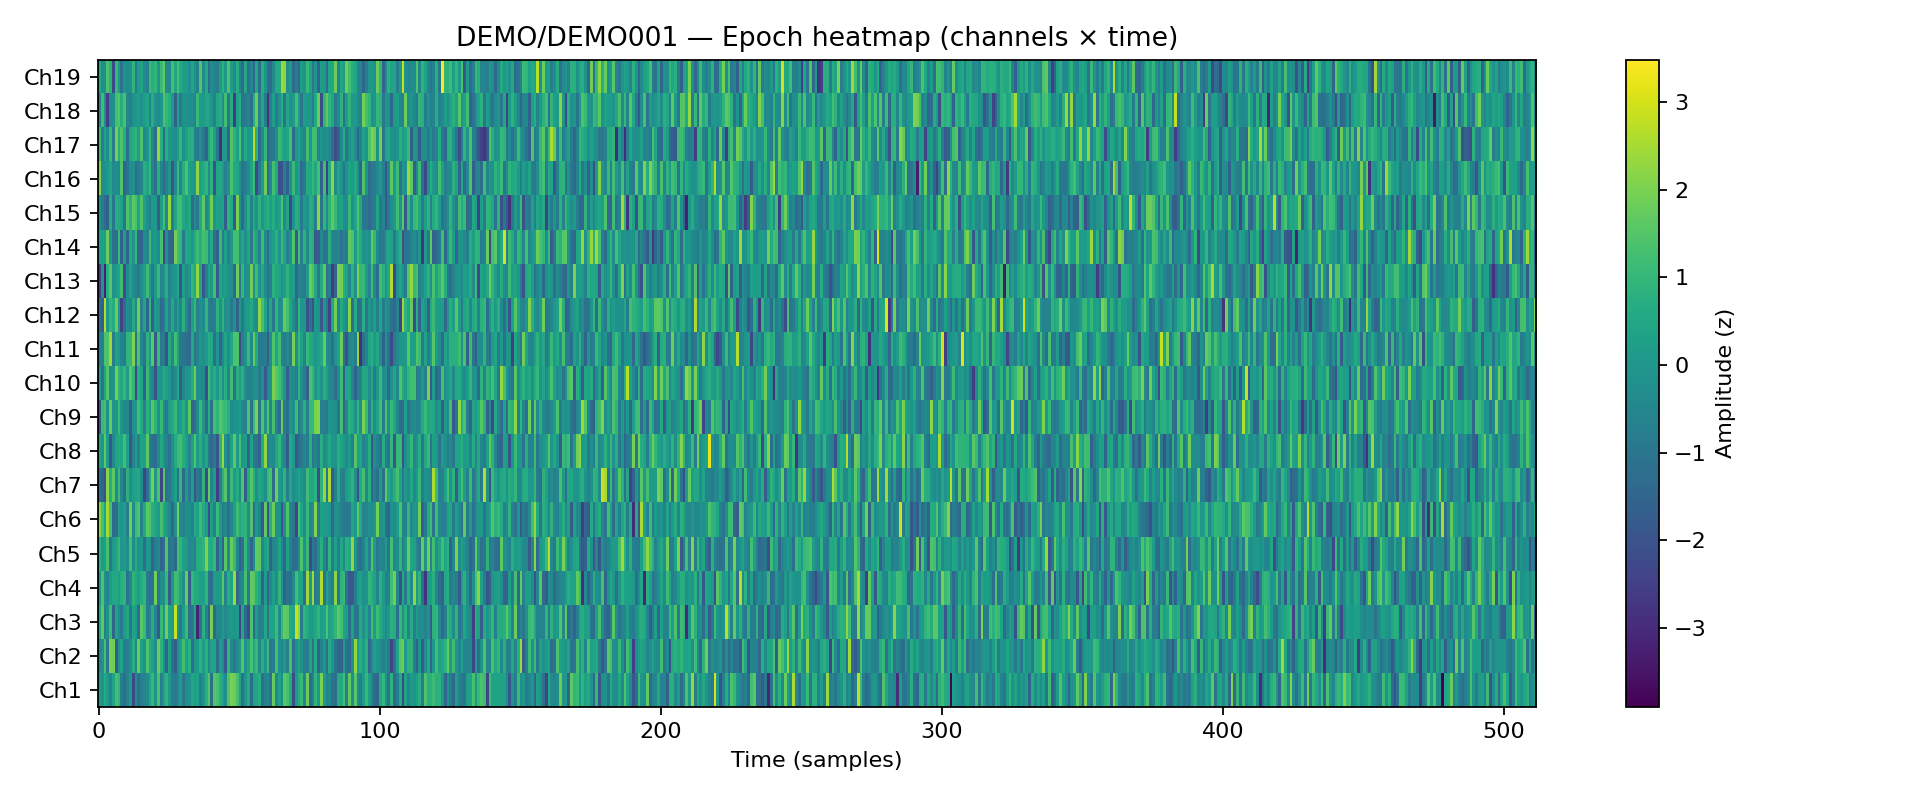

/content/data/preprocessing/figures/DEMO/DEMO001_psd.png


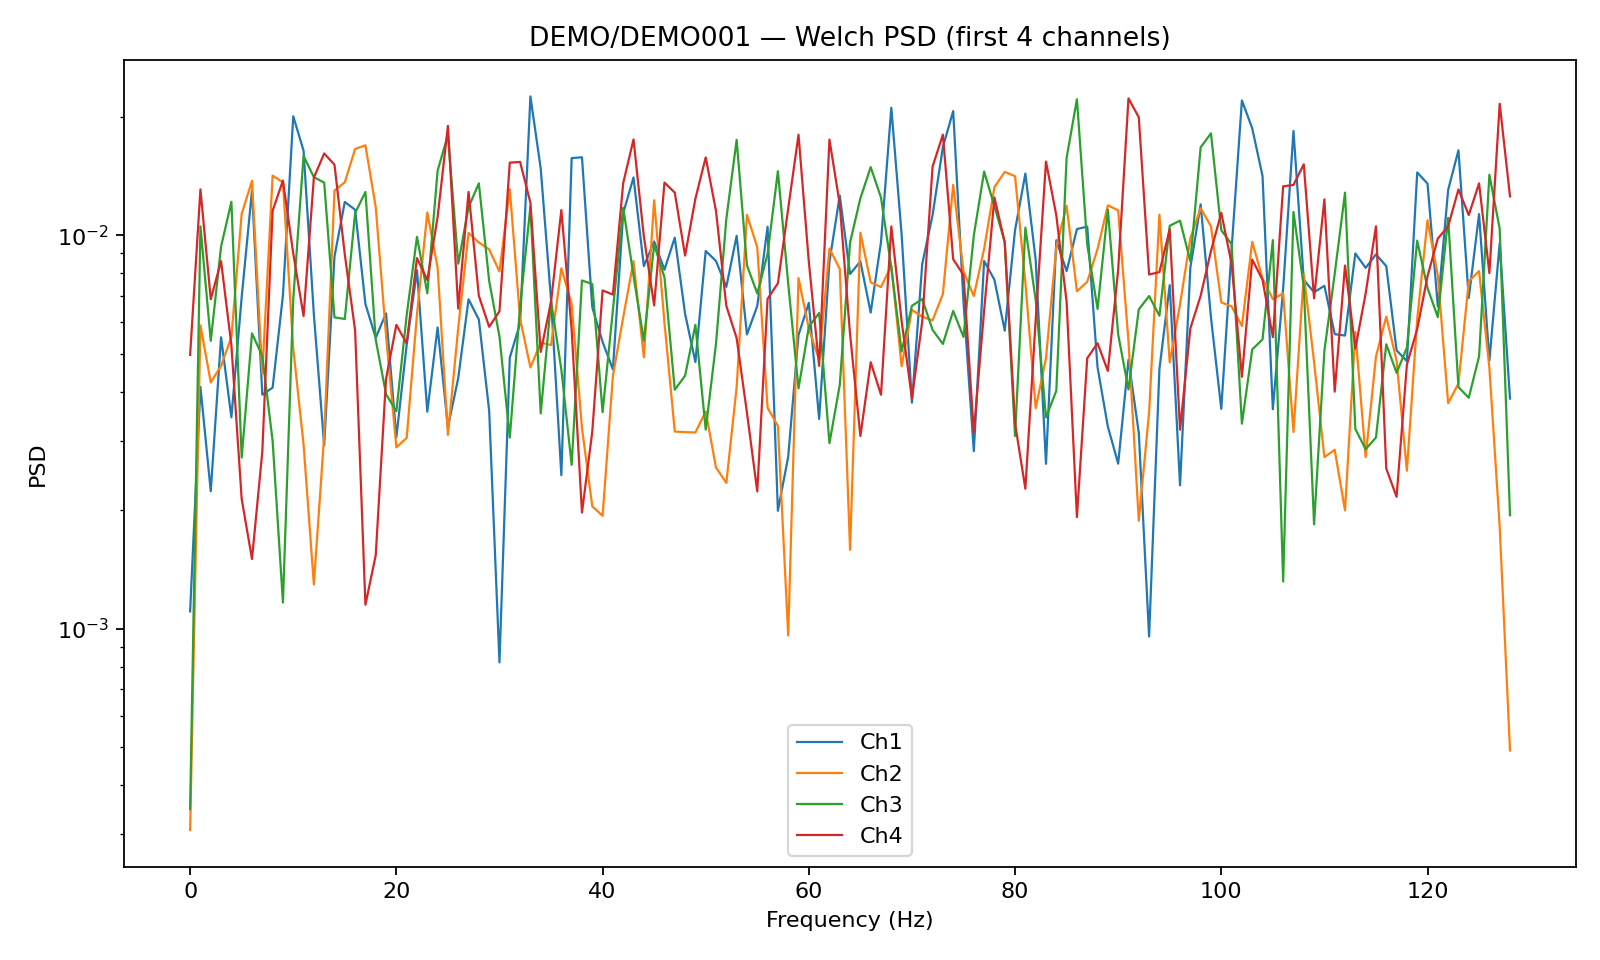

/content/data/preprocessing/figures/DEMO/DEMO001_rms.png


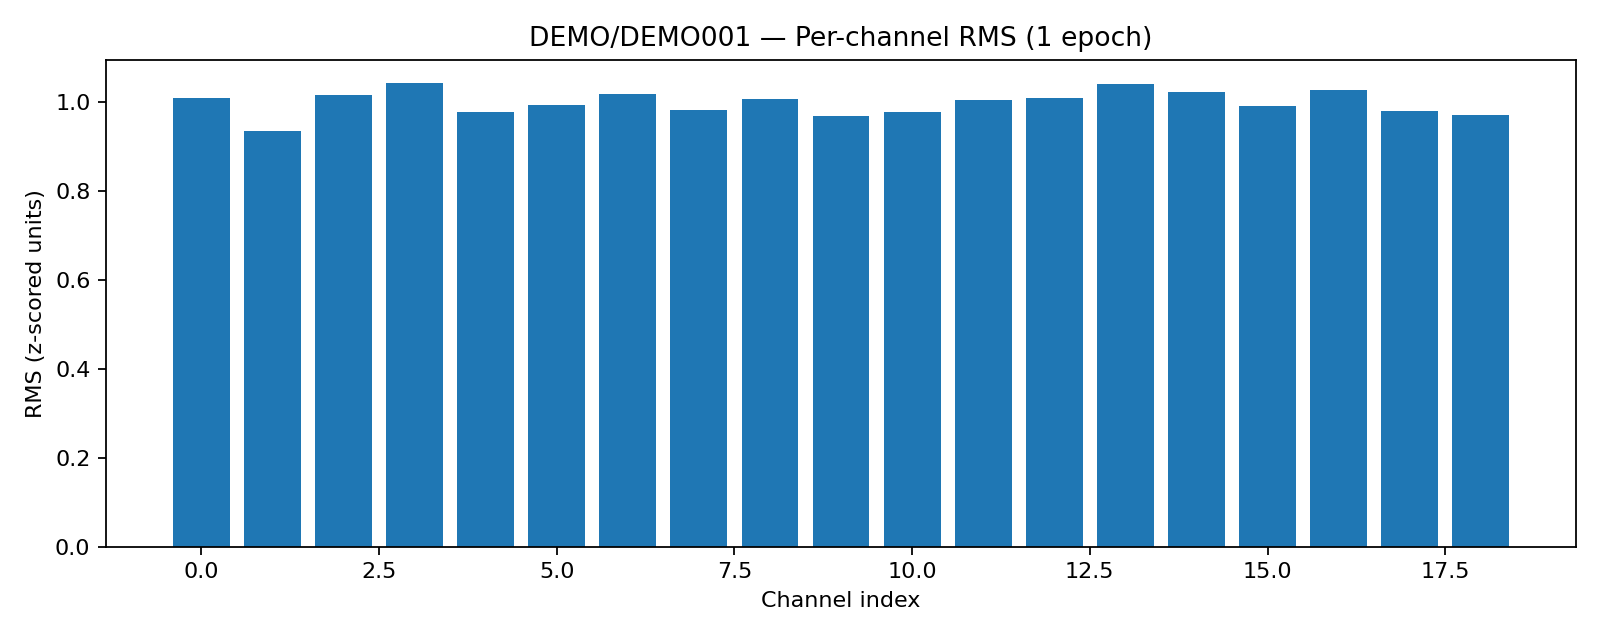

/content/data/preprocessing/figures/DEMO/DEMO001_stacked.png


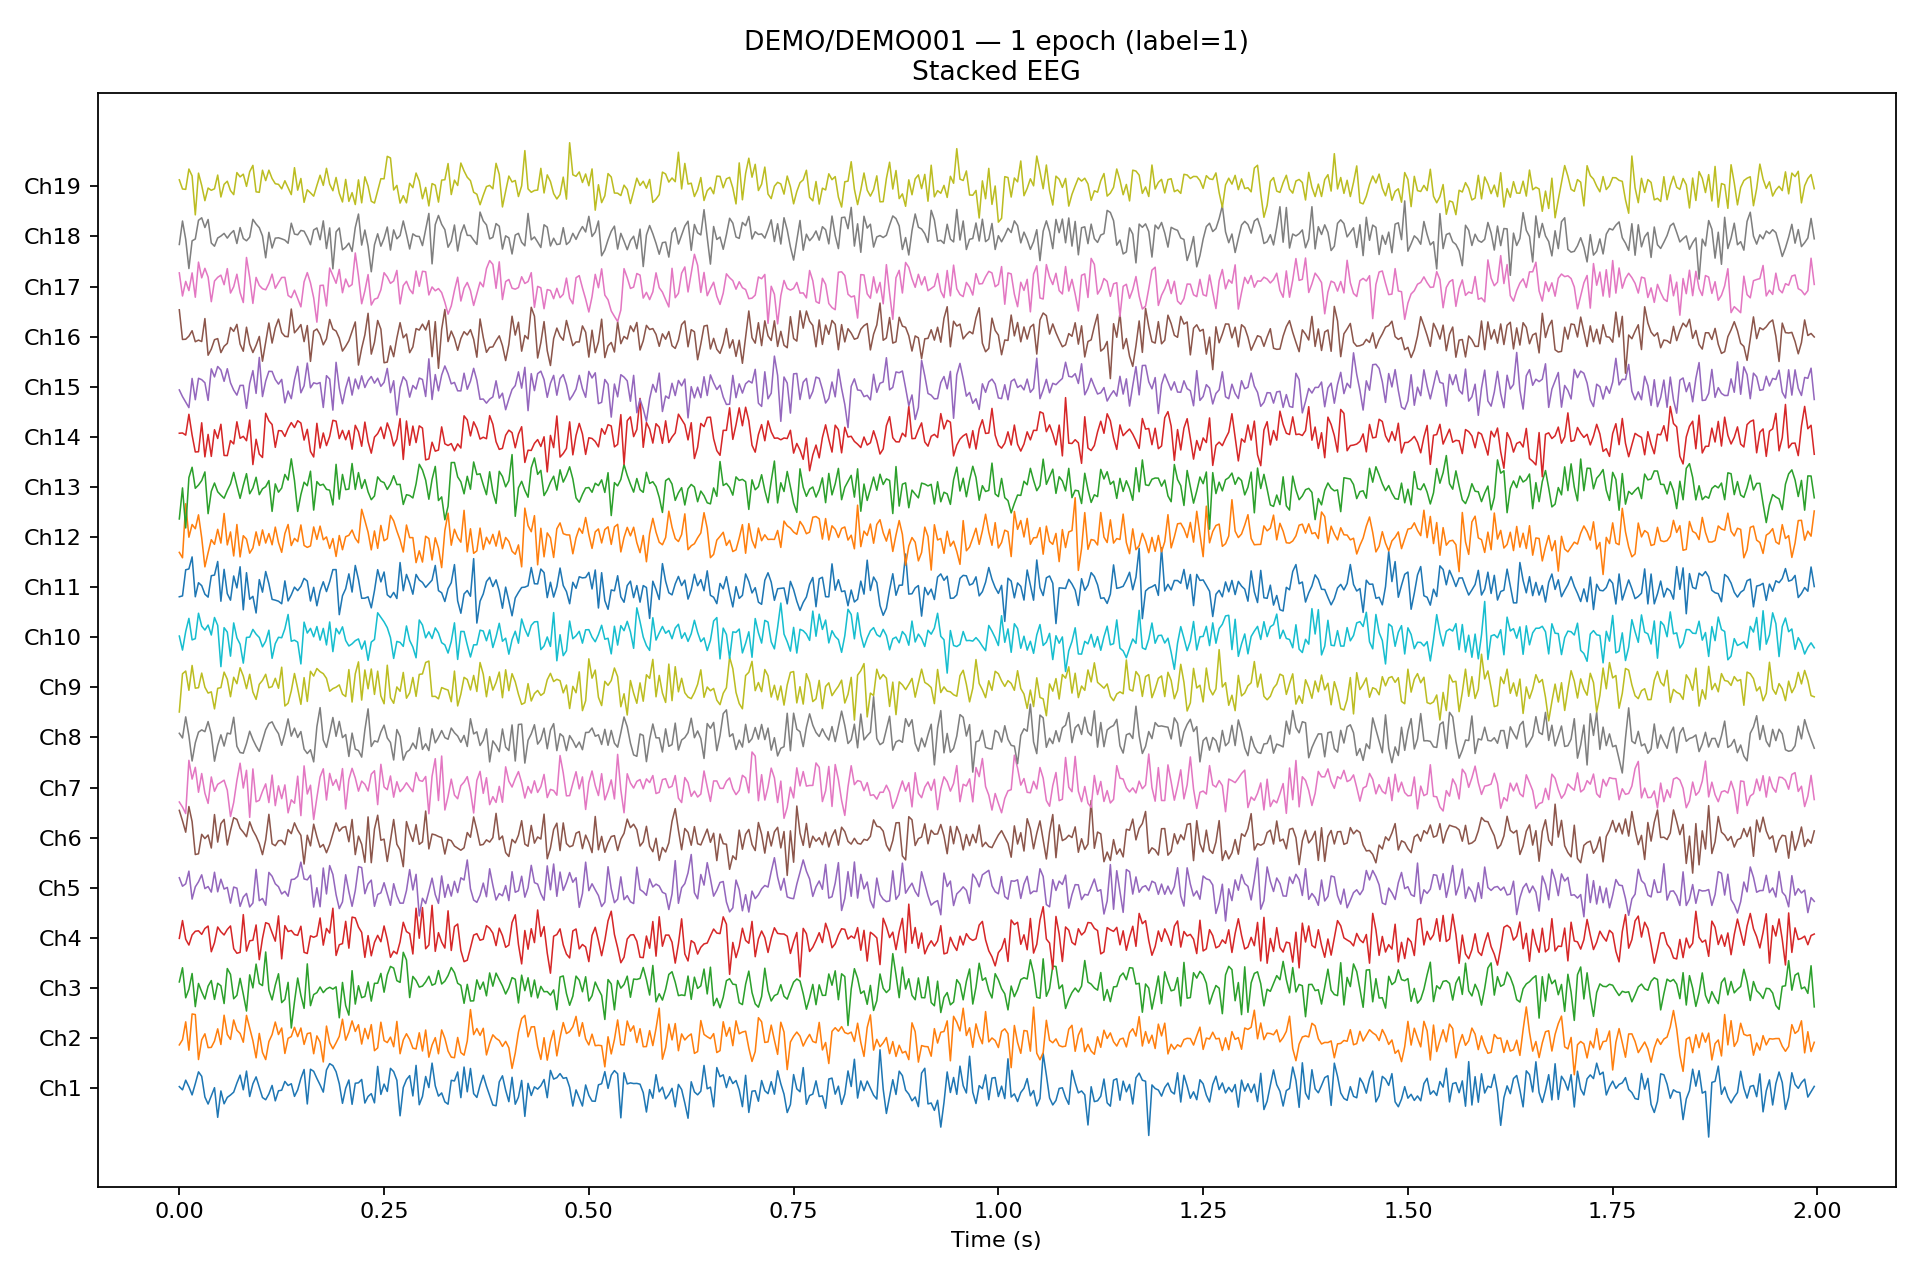

In [ ]:
import os, glob
from IPython.display import Image, display

ROOT = "/content/data"
fig_dir = os.path.join(ROOT, "preprocessing", "figures")


for path in sorted(glob.glob(os.path.join(fig_dir, "**", "*.png"), recursive=True))[:8]:
    print(path)
    display(Image(filename=path))

In [ ]:

ROOT = "/content/data"
OPENNEURO_ACCESSION = "ds002424"
OPENNEURO_INCLUDE = ["sub-01"]


!pip -q install mne pandas numpy scipy matplotlib >/dev/null

!npm i -g @openneuro/cli >/dev/null

import os, shutil, glob
os.makedirs(f"{ROOT}/raw/openneuro-ds002424", exist_ok=True)


for inc in OPENNEURO_INCLUDE:
    print(f"▼ Downloading {OPENNEURO_ACCESSION} :: include {inc}")
    !openneuro download {OPENNEURO_ACCESSION} {ROOT}/raw/openneuro-ds002424 --include {inc}

print("Sample EEG files downloaded:")
for p in sorted(glob.glob(f"{ROOT}/raw/openneuro-ds002424/**/*.*", recursive=True))[:10]:
    print("  -", p)


npm warn deprecated @openneuro/cli@4.30.2: These tools are deprecated with OpenNeuro 4.30.0. See https://jsr.io/@openneuro/cli for the new command line tools.
npm warn deprecated glob@7.2.3: Glob versions prior to v9 are no longer supported
npm warn deprecated inflight@1.0.6: This module is not supported, and leaks memory. Do not use it. Check out lru-cache if you want a good and tested way to coalesce async requests by a key value, which is much more comprehensive and powerful.
npm warn deprecated subscriptions-transport-ws@0.11.0: The `subscriptions-transport-ws` package is no longer maintained. We recommend you use `graphql-ws` instead. For help migrating Apollo software to `graphql-ws`, see https://www.apollographql.com/docs/apollo-server/data/subscriptions/#switching-from-subscriptions-transport-ws    For general help using `graphql-ws`, see https://github.com/enisdenjo/graphql-ws/blob/master/README.md
▼ Downloading ds002424 :: include sub-01
error: unknown option '--include'
Samp

Manifests created in: /content/data/manifests
[DEMO/DEMO001] -> 10 epochs | saved: /content/data/preprocessing/DEMO/DEMO001.npz


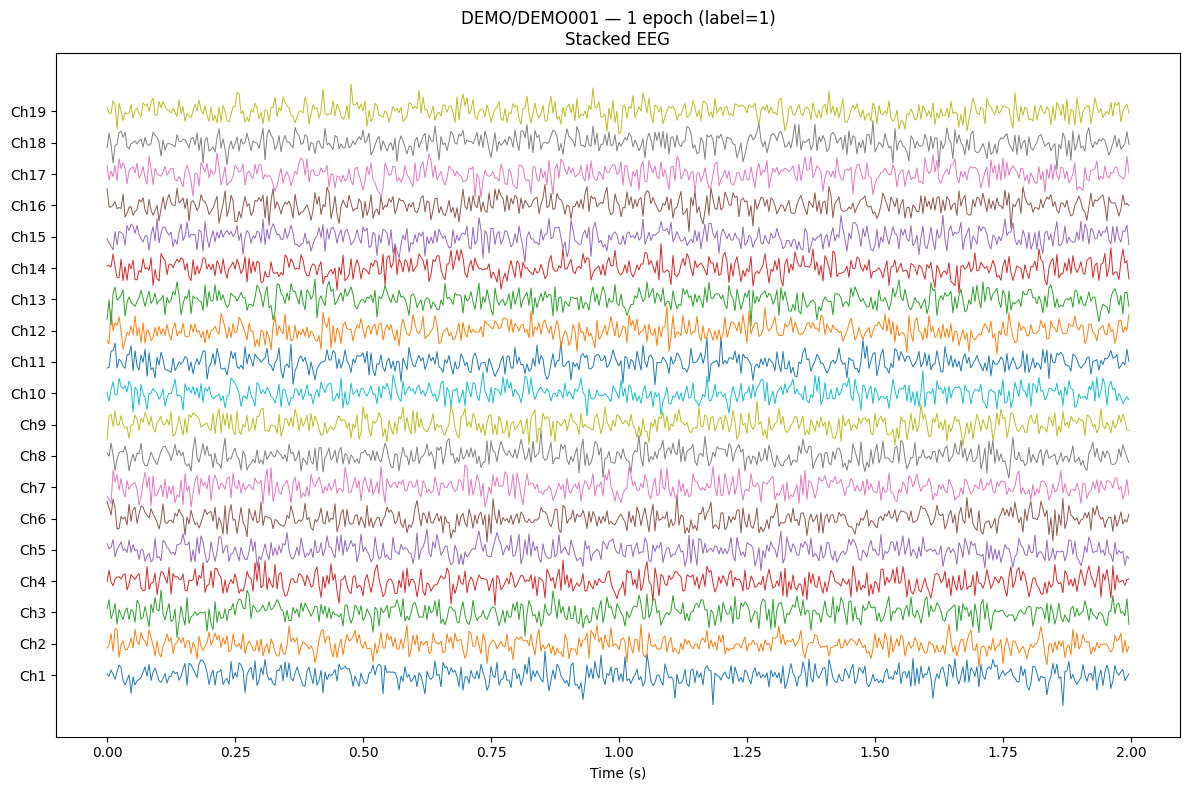

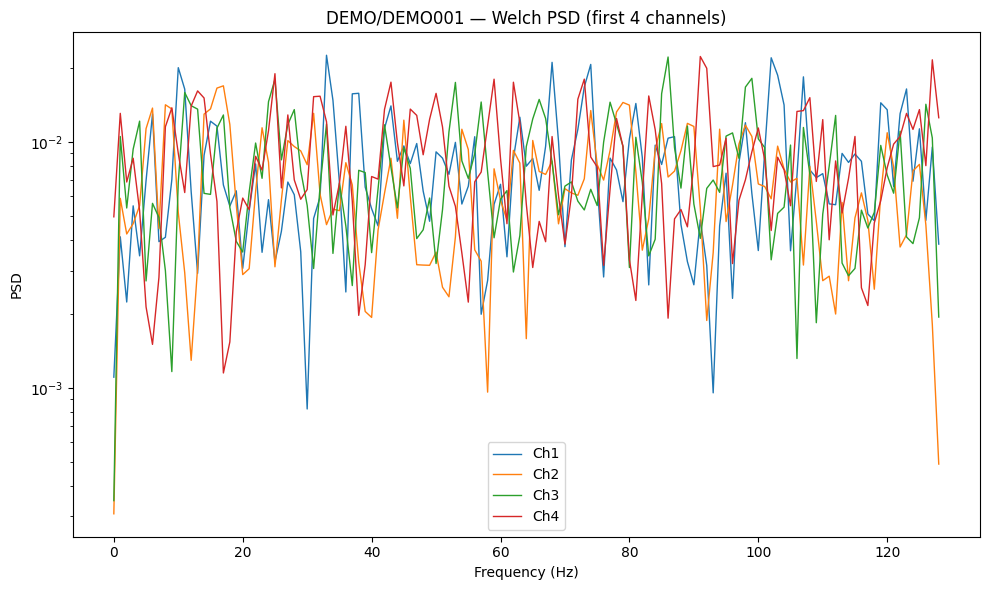

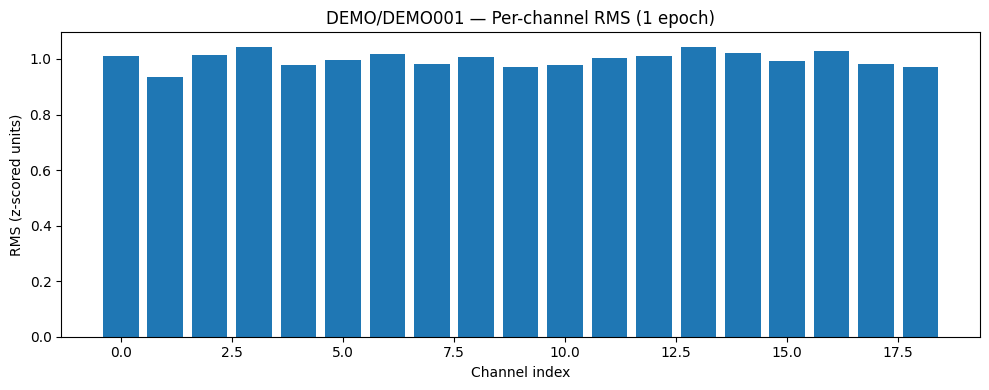

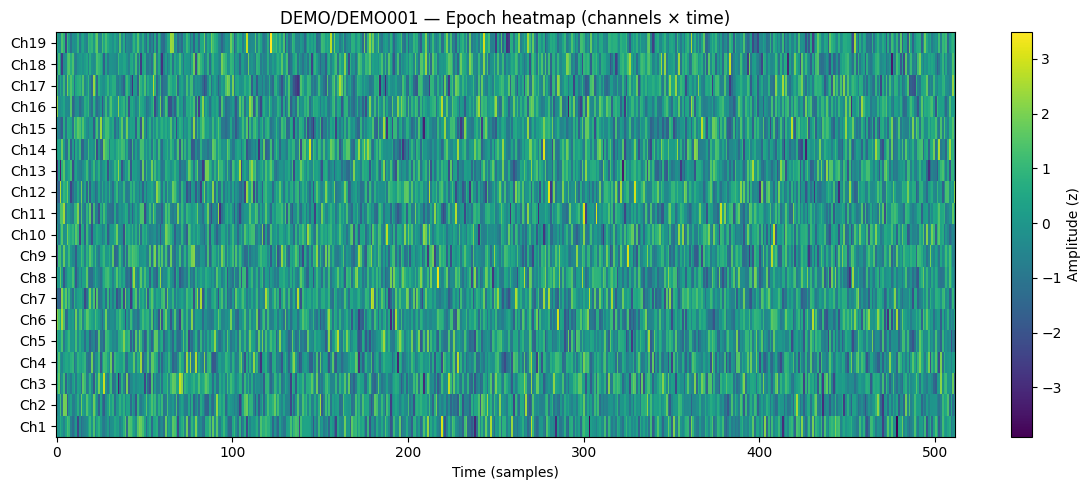

✅ Done.
Metadata: /content/data/preprocessing/metadata.csv
Figures saved under: /content/data/preprocessing/figures


In [ ]:
import os, re, csv, glob, pathlib
from pathlib import Path
import numpy as np
import pandas as pd
import mne
import matplotlib.pyplot as plt

try:
    from scipy.signal import welch as _welch
    def _psd_welch(x, fs, nperseg): return _welch(x, fs=fs, nperseg=nperseg)
except Exception:
    def _psd_welch(x, fs, nperseg):
        X = np.fft.rfft(x, n=nperseg); Pxx = (np.abs(X)**2)/(fs*nperseg); f = np.fft.rfftfreq(nperseg, 1.0/fs)
        return f, Pxx

# ---------- PIPELINE CONFIG ----------
EPOCH_LEN = 2.0
EPOCH_OVERLAP = 0.5
NOTCH_FREQ = 50.0
N_JOBS = 2
RANDOM_SEED = 23
TARGET_SFREQ = 256.0
BANDPASS = (0.5, 40.0)

DATASETS = {"OPENNEURO_DS002424": "raw/openneuro-ds002424"}
STANDARD_19 = ["Fp1","Fp2","F7","F3","Fz","F4","F8","T3","C3","Cz","C4","T4","T5","P3","Pz","P4","T6","O1","O2"]
CANONICAL_RENAMES = {"FP1":"Fp1","FP2":"Fp2","FZ":"Fz","CZ":"Cz","PZ":"Pz","O1":"O1","O2":"O2","A1":"T3","A2":"T4"}
LABEL_MAP = {"ADHD":1,"ADHD-1":1,"ADHD-2":1,"CONTROL":0,"NORMAL":0,"HEALTHY":0,"CONTROLLED":0,"CN":0}

SHOW_PLOTS_INLINE = True
MAX_INLINE_PREVIEWS = 2


def ensure_dirs():
    os.makedirs(ROOT, exist_ok=True)
    os.makedirs(os.path.join(ROOT, "manifests"), exist_ok=True)
    os.makedirs(os.path.join(ROOT, "preprocessing"), exist_ok=True)
    os.makedirs(os.path.join(ROOT, "preprocessing", "figures"), exist_ok=True)
    for _, rel in DATASETS.items():
        os.makedirs(os.path.join(ROOT, rel), exist_ok=True)

def guess_label_from_name(path: str) -> str:
    n = os.path.basename(path).lower()
    if "adhd" in n: return "ADHD"
    if re.search(r"(control|normal|hc|ctr|cn)", n): return "CONTROL"

    return "CONTROL"

def build_manifest_for(root: str, dataset_code: str, outfile: str):
    paths = []
    for ext in ("*.edf","*.bdf","*.gdf","*.fif","*.set","*.vhdr"):
        paths += glob.glob(os.path.join(root, "**", ext), recursive=True)
    with open(outfile, "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(["filepath","subject_id","label","dataset"])
        for p in sorted(paths):
            sid = pathlib.Path(p).stem[:32].upper()
            lbl = guess_label_from_name(p)
            w.writerow([os.path.abspath(p), sid, lbl, dataset_code])

def generate_manifests():
    manif_dir = os.path.join(ROOT, "manifests")
    for code, rel in DATASETS.items():
        src = os.path.join(ROOT, rel)
        out = os.path.join(manif_dir, f"{code.lower()}.csv")
        build_manifest_for(src, code, out)
    print("Manifests created in:", manif_dir)

def load_manifests() -> pd.DataFrame:
    csvs = sorted(glob.glob(os.path.join(ROOT, "manifests", "*.csv")))
    frames = []
    for c in csvs:
        df = pd.read_csv(c)
        if not set(["filepath","subject_id","label","dataset"]).issubset(df.columns):
            raise ValueError(f"Manifest {c} missing required columns")
        frames.append(df)
    if not frames:
        raise FileNotFoundError("No manifests found—did you put files in raw/ folders?")
    return pd.concat(frames, ignore_index=True)

def normalize_label(lbl: str) -> int:
    key = str(lbl).strip().upper()
    if key in LABEL_MAP: return LABEL_MAP[key]
    if key.startswith("CTRL"): return 0
    return 1 if "ADHD" in key else 0

def clean_ch_names(raw: mne.io.BaseRaw) -> None:
    new_names = {}
    for ch in raw.ch_names:
        c = ch.strip().replace(" ","").replace("-","")
        if c.upper() in CANONICAL_RENAMES:
            new_names[ch] = CANONICAL_RENAMES[c.upper()]
            continue
        c2 = c.replace("FP","Fp").replace("FZ","Fz").replace("CZ","Cz").replace("PZ","Pz")
        if len(c2) >= 2 and c2[0].isalpha():
            c2 = c2[0].upper() + c2[1:]
        new_names[ch] = c2
    raw.rename_channels(new_names)

def ensure_montage(raw: mne.io.BaseRaw):
    try:
        montage = mne.channels.make_standard_montage("standard_1020")
        raw.set_montage(montage, on_missing="ignore")
    except Exception as e:
        print("Montage warn:", e)

def pick_or_project_19(raw: mne.io.BaseRaw) -> mne.io.BaseRaw:
    present = [ch for ch in STANDARD_19 if ch in raw.ch_names]
    if len(present) == 19:
        return raw.pick(STANDARD_19, allow_empty=False).copy()
    raw2 = raw.copy()
    try:
        if raw2.get_montage() is not None and len(present) >= 12:
            raw2.info["bads"] = [ch for ch in STANDARD_19 if ch in raw2.info["ch_names"] and ch not in present]
            raw2.interpolate_bads(reset_bads=True, verbose=False)
    except Exception as e:
        print("Interpolation warn:", e)
    picks = [ch for ch in STANDARD_19 if ch in raw2.ch_names]
    return raw2.pick(picks).copy()

def run_ica(raw: mne.io.BaseRaw, random_state: int = RANDOM_SEED) -> mne.io.BaseRaw:
    n_components = min(15, len(raw.ch_names))
    ica = mne.preprocessing.ICA(n_components=n_components, random_state=random_state, method="fastica")
    with mne.utils.use_log_level("WARNING"):
        ica.fit(raw, picks="eeg", reject_by_annotation=True)
    eog_inds = []
    for eog_ch in ["EOG","VEOG","HEOG"]:
        if eog_ch in raw.ch_names:
            inds, _ = ica.find_bads_eog(raw, ch_name=eog_ch)
            eog_inds.extend(inds)
    if not eog_inds:
        eog_inds = list(range(min(2, n_components)))
    ica.exclude = sorted(set(eog_inds))
    return ica.apply(raw.copy())

def epoch_raw(raw: mne.io.BaseRaw, length_s: float, overlap: float) -> np.ndarray:
    step = max(1e-6, length_s*(1.0-overlap))
    sf = raw.info["sfreq"]
    win = int(round(length_s*sf))
    hop = max(1, int(round(step*sf)))
    data = raw.get_data(picks="eeg")
    n_times = data.shape[1]
    epochs = []
    for start in range(0, n_times - win + 1, hop):
        seg = data[:, start:start+win]
        if seg.shape[1] < win or np.any(np.isnan(seg)): continue
        mu = seg.mean(axis=1, keepdims=True)
        sd = seg.std(axis=1, keepdims=True) + 1e-8
        seg = (seg - mu) / sd
        epochs.append(seg.astype(np.float32))
    if not epochs:
        return np.zeros((0, len(raw.ch_names), win), dtype=np.float32)
    return np.stack(epochs, axis=0)

def read_raw_any(fp: str) -> mne.io.BaseRaw:
    ext = fp.lower().split(".")[-1]
    if ext in ("edf","bdf","gdf"):
        return mne.io.read_raw_edf(fp, preload=True, verbose=False)
    if ext in ("fif",):
        return mne.io.read_raw_fif(fp, preload=True, verbose=False)
    if ext in ("set",):
        return mne.io.read_raw_eeglab(fp, preload=True, verbose=False)
    if ext in ("vhdr",):
        return mne.io.read_raw_brainvision(fp, preload=True, verbose=False)
    return mne.io.read_raw(fp, preload=True, verbose=False)

def preprocess_file(filepath, subject_id, label_str, dataset, out_root):
    label = normalize_label(label_str)
    raw = read_raw_any(filepath)
    clean_ch_names(raw)
    ensure_montage(raw)
    raw.pick_types(eeg=True, eog=True, stim=False, meg=False)
    raw.load_data()

    raw.filter(BANDPASS[0], BANDPASS[1], picks="eeg", n_jobs=N_JOBS, verbose=False)
    if NOTCH_FREQ is not None:
        raw.notch_filter(freqs=[NOTCH_FREQ], picks="eeg", n_jobs=N_JOBS, verbose=False)

    if abs(raw.info["sfreq"] - TARGET_SFREQ) > 1e-6:
        raw.resample(sfreq=TARGET_SFREQ, npad="auto", verbose=False)

    raw = pick_or_project_19(raw)

    try:
        if raw.n_times / raw.info["sfreq"] >= 60.0:
            raw = run_ica(raw)
    except Exception as e:
        print("ICA warn:", e)

    try:
        raw.set_eeg_reference("average", projection=False, verbose=False)
    except Exception as e:
        print("CAR warn:", e)

    X = epoch_raw(raw, EPOCH_LEN, EPOCH_OVERLAP)

    out_dir = Path(os.path.join(ROOT, "preprocessing")) / dataset
    out_dir.mkdir(parents=True, exist_ok=True)
    out_npz = str(out_dir / f"{subject_id}.npz")
    np.savez_compressed(out_npz, x=X, y=np.int64(label))

    n_epochs = int(X.shape[0])
    n_channels = int(X.shape[1]) if n_epochs > 0 else len(raw.ch_names)
    return out_npz, n_epochs, n_channels, int(label), X

def plot_subject_epoch_set(npz_path, X, y, dataset, subject_id, out_root, show_inline=False):
    figures_dir = Path(out_root) / "figures" / dataset
    figures_dir.mkdir(parents=True, exist_ok=True)

    n_epochs, n_channels, T = X.shape
    if n_epochs == 0:
        return
    epoch = X[0]
    sfreq = TARGET_SFREQ
    times = np.arange(T) / sfreq


    plt.figure(figsize=(12, 8))
    offset = 4.0
    for ch in range(n_channels):
        plt.plot(times, epoch[ch] + ch * offset, linewidth=0.7)
    plt.yticks([i * offset for i in range(n_channels)], [f"Ch{i+1}" for i in range(n_channels)])
    plt.xlabel("Time (s)")
    plt.title(f"{dataset}/{subject_id} — 1 epoch (label={y})\nStacked EEG")
    plt.tight_layout()
    p1 = figures_dir / f"{subject_id}_stacked.png"
    plt.savefig(p1, dpi=160)
    if show_inline: plt.show()
    plt.close()


    plt.figure(figsize=(10, 6))
    for ch in [0, 1, 2, 3][:n_channels]:
        nper = min(256, T)
        f, Pxx = _psd_welch(epoch[ch], fs=sfreq, nperseg=nper)
        plt.semilogy(f, Pxx, linewidth=1.0, label=f"Ch{ch+1}")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("PSD")
    plt.title(f"{dataset}/{subject_id} — Welch PSD (first 4 channels)")
    plt.legend()
    plt.tight_layout()
    p2 = figures_dir / f"{subject_id}_psd.png"
    plt.savefig(p2, dpi=160)
    if show_inline: plt.show()
    plt.close()


    rms = np.sqrt((epoch**2).mean(axis=1))
    plt.figure(figsize=(10, 4))
    plt.bar(np.arange(n_channels), rms)
    plt.xlabel("Channel index")
    plt.ylabel("RMS (z-scored units)")
    plt.title(f"{dataset}/{subject_id} — Per-channel RMS (1 epoch)")
    plt.tight_layout()
    p3 = figures_dir / f"{subject_id}_rms.png"
    plt.savefig(p3, dpi=160)
    if show_inline: plt.show()
    plt.close()


    plt.figure(figsize=(12, 5))
    plt.imshow(epoch, aspect="auto", interpolation="nearest", origin="lower")
    plt.colorbar(label="Amplitude (z)")
    plt.yticks(np.arange(n_channels), [f"Ch{i+1}" for i in range(n_channels)])
    plt.xlabel("Time (samples)")
    plt.title(f"{dataset}/{subject_id} — Epoch heatmap (channels × time)")
    plt.tight_layout()
    p4 = figures_dir / f"{subject_id}_heatmap.png"
    plt.savefig(p4, dpi=160)
    if show_inline: plt.show()
    plt.close()


np.random.seed(RANDOM_SEED)
ensure_dirs()

# 1) Manifests from downloaded files
generate_manifests()
df = load_manifests()

# 2) Preprocess everything we actually have on disk
meta_csv = os.path.join(ROOT, "preprocessing", "metadata.csv")
totals_files, totals_epochs = 0, 0
inline_shown = 0

with open(meta_csv, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["dataset","subject_id","npz_path","label","n_epochs","n_channels","sfreq","epoch_len","epoch_overlap"])

    for _, row in df.iterrows():
        fp = str(row["filepath"])
        if not os.path.exists(fp):
            continue

        npz_path, n_ep, n_ch, label, X = preprocess_file(
            filepath=fp,
            subject_id=str(row["subject_id"]),
            label_str=str(row["label"]),
            dataset=str(row["dataset"]),
            out_root=os.path.join(ROOT, "preprocessing")
        )
        w.writerow([row["dataset"], row["subject_id"], npz_path, label, n_ep, n_ch,
                    TARGET_SFREQ, EPOCH_LEN, EPOCH_OVERLAP])
        totals_files += 1
        totals_epochs += n_ep
        print(f"[{row['dataset']}/{row['subject_id']}] -> {n_ep} epochs | saved: {npz_path}")

        # Save plots + show a couple inline
        show_now = SHOW_PLOTS_INLINE and (inline_shown < MAX_INLINE_PREVIEWS)
        plot_subject_epoch_set(npz_path, X, label, str(row["dataset"]), str(row["subject_id"]),
                               out_root=os.path.join(ROOT, "preprocessing"),
                               show_inline=show_now)
        if show_now:
            inline_shown += 1

if totals_files == 0:
    demo_dir = Path(ROOT) / "preprocessing" / "DEMO"
    demo_fig_dir = Path(ROOT) / "preprocessing" / "figures" / "DEMO"
    demo_dir.mkdir(parents=True, exist_ok=True)
    demo_fig_dir.mkdir(parents=True, exist_ok=True)

    rng = np.random.default_rng(0)
    X = rng.normal(0, 1, size=(10, 19, int(EPOCH_LEN * TARGET_SFREQ))).astype(np.float32)
    npz_path = str(demo_dir / "DEMO001.npz")
    np.savez_compressed(npz_path, x=X, y=np.int64(1))

    with open(meta_csv, "a", newline="") as f:
        w = csv.writer(f)
        w.writerow(["DEMO", "DEMO001", npz_path, 1, X.shape[0], X.shape[1],
                    TARGET_SFREQ, EPOCH_LEN, EPOCH_OVERLAP])

    print(f"[DEMO/DEMO001] -> {X.shape[0]} epochs | saved: {npz_path}")
    plot_subject_epoch_set(npz_path, X, 1, "DEMO", "DEMO001",
                           out_root=os.path.join(ROOT, "preprocessing"),
                           show_inline=True)

print("✅ Done.")
print("Metadata:", meta_csv)
print("Figures saved under:", os.path.join(ROOT, "preprocessing", "figures"))


In [ ]:
import os, re, csv, glob, pathlib
from pathlib import Path
import numpy as np
import pandas as pd
import mne
import matplotlib.pyplot as plt

from scipy.signal import welch as _welch


ROOT = "/content/data"
EPOCH_LEN = 2.0
EPOCH_OVERLAP = 0.5
NOTCH_FREQ = 50.0
N_JOBS = 2
RANDOM_SEED = 23
TARGET_SFREQ = 256.0
BANDPASS = (0.5, 40.0)

DATASETS = {
    "OPENNEURO_DS002424": "raw/openneuro-ds002424",
    "TUH_EEG": "raw/tuh_eeg",
    "IEEE_DATAPORT": "raw/ieee_dataport",
    "SRM_MCH": "raw/srm_mch",
}

STANDARD_19 = ["Fp1","Fp2","F7","F3","Fz","F4","F8","T3","C3","Cz","C4","T4","T5","P3","Pz","P4","T6","O1","O2"]
CANONICAL_RENAMES = {"FP1":"Fp1","FP2":"Fp2","FZ":"Fz","CZ":"Cz","PZ":"Pz","O1":"O1","O2":"O2","A1":"T3","A2":"T4"}
LABEL_MAP = {"ADHD":1,"ADHD-1":1,"ADHD-2":1,"CONTROL":0,"NORMAL":0,"HEALTHY":0,"CONTROLLED":0,"CN":0}

SHOW_PLOTS_INLINE = True
MAX_INLINE_PREVIEWS = 2
FRONTAL_CHANNELS_PREF = ["Fp1","Fp2","F7","F3","Fz","F4","F8","Cz","C3","C4"]  # used for before/after overlay


def ensure_dirs():
    os.makedirs(ROOT, exist_ok=True)
    os.makedirs(os.path.join(ROOT, "manifests"), exist_ok=True)
    os.makedirs(os.path.join(ROOT, "preprocessing"), exist_ok=True)
    os.makedirs(os.path.join(ROOT, "preprocessing", "figures"), exist_ok=True)
    for _, rel in DATASETS.items():
        os.makedirs(os.path.join(ROOT, rel), exist_ok=True)

def guess_label_from_name(path: str) -> str:
    n = os.path.basename(path).lower()
    if "adhd" in n: return "ADHD"
    if re.search(r"(control|normal|hc|ctr|cn)", n): return "CONTROL"
    return "CONTROL"

def build_manifest_for(root: str, dataset_code: str, outfile: str):
    paths = []
    for ext in ("*.edf","*.bdf","*.gdf","*.fif","*.set","*.vhdr"):
        paths += glob.glob(os.path.join(root, "**", ext), recursive=True)
    with open(outfile, "w", newline="") as f:
        w = csv.writer(f)
        w.writerow(["filepath","subject_id","label","dataset"])
        for p in sorted(paths):
            sid = pathlib.Path(p).stem[:32].upper()
            lbl = guess_label_from_name(p)
            w.writerow([os.path.abspath(p), sid, lbl, dataset_code])

def generate_manifests():
    manif_dir = os.path.join(ROOT, "manifests")
    for code, rel in DATASETS.items():
        src = os.path.join(ROOT, rel)
        out = os.path.join(manif_dir, f"{code.lower()}.csv")
        build_manifest_for(src, code, out)
    print("Manifests created in:", manif_dir)

def load_manifests() -> pd.DataFrame:
    csvs = sorted(glob.glob(os.path.join(ROOT, "manifests", "*.csv")))
    frames = []
    for c in csvs:
        df = pd.read_csv(c)
        if not set(["filepath","subject_id","label","dataset"]).issubset(df.columns):
            raise ValueError(f"Manifest {c} missing required columns")
        frames.append(df)
    if not frames:
        raise FileNotFoundError("No manifests found—did you put files in raw/ folders?")
    return pd.concat(frames, ignore_index=True)

def normalize_label(lbl: str) -> int:
    key = str(lbl).strip().upper()
    if key in LABEL_MAP: return LABEL_MAP[key]
    if key.startswith("CTRL"): return 0
    return 1 if "ADHD" in key else 0

def clean_ch_names(raw: mne.io.BaseRaw) -> None:
    new_names = {}
    for ch in raw.ch_names:
        c = ch.strip().replace(" ","").replace("-","")
        if c.upper() in CANONICAL_RENAMES:
            new_names[ch] = CANONICAL_RENAMES[c.upper()]
            continue
        c2 = c.replace("FP","Fp").replace("FZ","Fz").replace("CZ","Cz").replace("PZ","Pz")
        if len(c2) >= 2 and c2[0].isalpha():
            c2 = c2[0].upper() + c2[1:]
        new_names[ch] = c2
    raw.rename_channels(new_names)

def ensure_montage(raw: mne.io.BaseRaw):
    try:
        montage = mne.channels.make_standard_montage("standard_1020")
        raw.set_montage(montage, on_missing="ignore")
    except Exception as e:
        print("Montage warn:", e)

def pick_or_project_19(raw: mne.io.BaseRaw) -> mne.io.BaseRaw:
    present = [ch for ch in STANDARD_19 if ch in raw.ch_names]
    if len(present) == 19:
        return raw.pick(STANDARD_19, allow_empty=False).copy()
    raw2 = raw.copy()
    try:
        if raw2.get_montage() is not None and len(present) >= 12:
            raw2.info["bads"] = [ch for ch in STANDARD_19 if ch in raw2.info["ch_names"] and ch not in present]
            raw2.interpolate_bads(reset_bads=True, verbose=False)
    except Exception as e:
        print("Interpolation warn:", e)
    picks = [ch for ch in STANDARD_19 if ch in raw2.ch_names]
    return raw2.pick(picks).copy()

def read_raw_any(fp: str) -> mne.io.BaseRaw:
    ext = fp.lower().split(".")[-1]
    if ext in ("edf","bdf","gdf"):
        return mne.io.read_raw_edf(fp, preload=True, verbose=False)
    if ext in ("fif",):
        return mne.io.read_raw_fif(fp, preload=True, verbose=False)
    if ext in ("set",):
        return mne.io.read_raw_eeglab(fp, preload=True, verbose=False)
    if ext in ("vhdr",):
        return mne.io.read_raw_brainvision(fp, preload=True, verbose=False)
    return mne.io.read_raw(fp, preload=True, verbose=False)


def remove_artifacts_via_ica(raw: mne.io.BaseRaw, random_state: int = RANDOM_SEED):

    n_components = min(15, len(raw.ch_names))
    ica = mne.preprocessing.ICA(n_components=n_components, random_state=random_state, method="fastica")
    with mne.utils.use_log_level("WARNING"):
        ica.fit(raw, picks="eeg", reject_by_annotation=True)

    eog_inds = []

    for eog_ch in ["EOG", "VEOG", "HEOG"]:
        if eog_ch in raw.ch_names:
            inds, _ = ica.find_bads_eog(raw, ch_name=eog_ch)
            eog_inds.extend(inds)

    if not eog_inds:
        eog_inds = list(range(min(2, n_components)))

    ica.exclude = sorted(set(eog_inds))
    raw_clean = ica.apply(raw.copy())

    return raw_clean, ica.exclude

def epoch_raw(raw: mne.io.BaseRaw, length_s: float, overlap: float) -> np.ndarray:
    step = max(1e-6, length_s*(1.0-overlap))
    sf = raw.info["sfreq"]
    win = int(round(length_s*sf))
    hop = max(1, int(round(step*sf)))
    data = raw.get_data(picks="eeg")
    n_times = data.shape[1]
    epochs = []
    for start in range(0, n_times - win + 1, hop):
        seg = data[:, start:start+win]
        if seg.shape[1] < win or np.any(np.isnan(seg)): continue
        mu = seg.mean(axis=1, keepdims=True)
        sd = seg.std(axis=1, keepdims=True) + 1e-8
        seg = (seg - mu) / sd
        epochs.append(seg.astype(np.float32))
    if not epochs:
        return np.zeros((0, len(raw.ch_names), win), dtype=np.float32)
    return np.stack(epochs, axis=0)

def normalize_label(lbl: str) -> int:
    key = str(lbl).strip().upper()
    if key in LABEL_MAP: return LABEL_MAP[key]
    if key.startswith("CTRL"): return 0
    return 1 if "ADHD" in key else 0

def _pick_channels_for_overlay(ch_names):
    # order by preference; fall back to whatever exists
    chosen = []
    for ch in FRONTAL_CHANNELS_PREF:
        if ch in ch_names:
            chosen.append(ch)
        if len(chosen) >= 5:
            break
    if not chosen:
        # If none matched, just take first 5 EEG channels
        chosen = ch_names[:5]
    return chosen

def plot_before_after(raw_before, raw_after, dataset, subject_id, out_root, show_inline=False):

    figs_dir = Path(out_root) / "figures" / dataset
    figs_dir.mkdir(parents=True, exist_ok=True)

    sf = raw_before.info["sfreq"]
    chs = _pick_channels_for_overlay(raw_before.ch_names)
    start = 0.0
    dur = min(10.0, raw_before.n_times / sf)


    s0 = int(start * sf)
    s1 = int((start + dur) * sf)
    Xb = raw_before.get_data(picks=chs)[:, s0:s1]
    Xa = raw_after.get_data(picks=chs)[:, s0:s1]
    t = np.arange(s1 - s0) / sf


    plt.figure(figsize=(12, 7))
    offset = 5.0
    for i, ch in enumerate(chs):
        plt.plot(t, Xb[i] + i*offset, linewidth=0.8, label="before" if i==0 else None)
        plt.plot(t, Xa[i] + i*offset, linewidth=0.8, alpha=0.9, label="after" if i==0 else None)
    plt.yticks([i*offset for i in range(len(chs))], chs)
    plt.xlabel("Time (s)")
    plt.title(f"{dataset}/{subject_id} — EOG/EMG removal: 10 s overlay")
    plt.legend()
    plt.tight_layout()
    out1 = figs_dir / f"{subject_id}_overlay_before_after.png"
    plt.savefig(out1, dpi=160)
    if show_inline: plt.show()
    plt.close()


    def avg_psd(arr):
        f, P = _welch(arr, fs=sf, nperseg=min(256, arr.shape[-1]), axis=-1)

        return f, P.mean(axis=0)
    fb, Pb = avg_psd(Xb)
    fa, Pa = avg_psd(Xa)

    plt.figure(figsize=(10, 6))
    plt.semilogy(fb, Pb, linewidth=1.2, label="before")
    plt.semilogy(fa, Pa, linewidth=1.2, label="after")
    plt.axvspan(20, 40, alpha=0.15)  # typical muscle band (with our 40 Hz LP)
    plt.xlim(0, 45)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("PSD (avg over chosen channels)")
    plt.title(f"{dataset}/{subject_id} — PSD before/after (EMG band highlighted)")
    plt.legend()
    plt.tight_layout()
    out2 = figs_dir / f"{subject_id}_psd_before_after.png"
    plt.savefig(out2, dpi=160)
    if show_inline: plt.show()
    plt.close()


    rb = np.sqrt((Xb**2).mean(axis=1))
    ra = np.sqrt((Xa**2).mean(axis=1))
    plt.figure(figsize=(10, 4))
    idx = np.arange(len(chs))
    plt.bar(idx - 0.2, rb, width=0.4, label="before")
    plt.bar(idx + 0.2, ra, width=0.4, label="after")
    plt.xticks(idx, chs)
    plt.ylabel("RMS")
    plt.title(f"{dataset}/{subject_id} — RMS before vs after (10 s)")
    plt.legend()
    plt.tight_layout()
    out3 = figs_dir / f"{subject_id}_rms_before_after.png"
    plt.savefig(out3, dpi=160)
    if show_inline: plt.show()
    plt.close()


    def epochize(raw):
        sf = raw.info["sfreq"]
        win = int(round(EPOCH_LEN * sf))
        data = raw.get_data(picks="eeg")
        if data.shape[-1] < win:  # too short
            return None
        seg = data[:, :win]
        mu = seg.mean(axis=1, keepdims=True)
        sd = seg.std(axis=1, keepdims=True) + 1e-8
        return ((seg - mu) / sd)

    Eb = epochize(raw_before)
    Ea = epochize(raw_after)
    if Eb is not None and Ea is not None:
        plt.figure(figsize=(12, 4))
        plt.imshow(Eb, aspect="auto", interpolation="nearest", origin="lower")
        plt.colorbar(label="z")
        plt.yticks(np.arange(Eb.shape[0]), raw_before.ch_names[:Eb.shape[0]])
        plt.title(f"{dataset}/{subject_id} — Heatmap BEFORE (1st epoch)")
        plt.xlabel("Time (samples)")
        plt.tight_layout()
        out4a = figs_dir / f"{subject_id}_heatmap_before.png"
        plt.savefig(out4a, dpi=160)
        if show_inline: plt.show()
        plt.close()

        plt.figure(figsize=(12, 4))
        plt.imshow(Ea, aspect="auto", interpolation="nearest", origin="lower")
        plt.colorbar(label="z")
        plt.yticks(np.arange(Ea.shape[0]), raw_after.ch_names[:Ea.shape[0]])
        plt.title(f"{dataset}/{subject_id} — Heatmap AFTER (1st epoch)")
        plt.xlabel("Time (samples)")
        plt.tight_layout()
        out4b = figs_dir / f"{subject_id}_heatmap_after.png"
        plt.savefig(out4b, dpi=160)
        if show_inline: plt.show()
        plt.close()

def preprocess_one(filepath, subject_id, label_str, dataset, out_root):

    raw = read_raw_any(filepath)
    clean_ch_names(raw)
    ensure_montage(raw)
    raw.pick_types(eeg=True, eog=True, stim=False, meg=False)
    raw.load_data()


    raw.filter(BANDPASS[0], BANDPASS[1], picks="eeg", n_jobs=N_JOBS, verbose=False)
    if NOTCH_FREQ is not None:
        raw.notch_filter(freqs=[NOTCH_FREQ], picks="eeg", n_jobs=N_JOBS, verbose=False)


    if abs(raw.info["sfreq"] - TARGET_SFREQ) > 1e-6:
        raw.resample(sfreq=TARGET_SFREQ, npad="auto", verbose=False)


    raw_19 = pick_or_project_19(raw)

    # ---- Artifact removal (ICA) ----
    raw_before = raw_19.copy()
    try:
        raw_after, excluded = remove_artifacts_via_ica(raw_19)
    except Exception as e:
        print(f"ICA warn ({dataset}/{subject_id}):", e)
        raw_after = raw_19.copy()
        excluded = []

    # CAR
    try:
        raw_after.set_eeg_reference("average", projection=False, verbose=False)
    except Exception as e:
        print("CAR warn:", e)


    X = epoch_raw(raw_after, EPOCH_LEN, EPOCH_OVERLAP)
    label = normalize_label(label_str)

    out_dir = Path(out_root) / dataset
    out_dir.mkdir(parents=True, exist_ok=True)
    out_npz = str(out_dir / f"{subject_id}.npz")
    np.savez_compressed(out_npz, x=X, y=np.int64(label))


    plot_before_after(raw_before, raw_after, dataset, subject_id,
                      out_root=out_root, show_inline=False)

    return out_npz, int(X.shape[0]), int(X.shape[1]) if X.shape[0] else len(raw_after.ch_names), int(label)


np.random.seed(RANDOM_SEED)
ensure_dirs()


generate_manifests()
df = load_manifests()

meta_csv = os.path.join(ROOT, "preprocessing", "metadata.csv")
totals_files, totals_epochs, inline_count = 0, 0, 0

with open(meta_csv, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["dataset","subject_id","npz_path","label","n_epochs","n_channels","sfreq","epoch_len","epoch_overlap"])

    for _, row in df.iterrows():
        fp = str(row["filepath"])
        if not os.path.exists(fp):
            continue

        npz_path, n_ep, n_ch, label = preprocess_one(
            filepath=fp,
            subject_id=str(row["subject_id"]),
            label_str=str(row["label"]),
            dataset=str(row["dataset"]),
            out_root=os.path.join(ROOT, "preprocessing")
        )
        w.writerow([row["dataset"], row["subject_id"], npz_path, label, n_ep, n_ch,
                    TARGET_SFREQ, EPOCH_LEN, EPOCH_OVERLAP])
        totals_files += 1
        totals_epochs += n_ep
        print(f"[{row['dataset']}/{row['subject_id']}] -> {n_ep} epochs | saved: {npz_path}")

        if SHOW_PLOTS_INLINE and inline_count < MAX_INLINE_PREVIEWS:
            from IPython.display import Image, display
            figs_dir = Path(ROOT) / "preprocessing" / "figures" / str(row["dataset"])
            for suffix in ["overlay_before_after","psd_before_after","rms_before_after","heatmap_before","heatmap_after"]:
                p = figs_dir / f"{row['subject_id']}_{suffix}.png"
                if p.exists():
                    print("Preview:", p)
                    display(Image(filename=str(p)))
            inline_count += 1

if totals_files == 0:
    demo_dir = Path(ROOT) / "preprocessing" / "DEMO"
    demo_fig_dir = Path(ROOT) / "preprocessing" / "figures" / "DEMO"
    demo_dir.mkdir(parents=True, exist_ok=True)
    demo_fig_dir.mkdir(parents=True, exist_ok=True)
    rng = np.random.default_rng(0)
    X = rng.normal(0, 1, size=(10, 19, int(EPOCH_LEN * TARGET_SFREQ))).astype(np.float32)
    npz_path = str(demo_dir / "DEMO001.npz")
    np.savez_compressed(npz_path, x=X, y=np.int64(1))
    print(f"[DEMO/DEMO001] -> {X.shape[0]} demo epochs | saved: {npz_path}")

print("✅ Done.")
print("Metadata:", meta_csv)
print("Figures under:", os.path.join(ROOT, "preprocessing", "figures"))


Manifests created in: /content/data/manifests
[DEMO/DEMO001] -> 10 demo epochs | saved: /content/data/preprocessing/DEMO/DEMO001.npz
✅ Done.
Metadata: /content/data/preprocessing/metadata.csv
Figures under: /content/data/preprocessing/figures


In [ ]:

from scipy.signal import butter, filtfilt, welch

FRONTAL_PREF = ["Fp1","Fp2","F7","F3","Fz","F4","F8","Cz","C3","C4"]  # likely EOG channels

def _pick_time_window(raw, dur_s=2.0):
    """Pick a 2 s middle window like the example."""
    sf = raw.info["sfreq"]
    dur_s = min(dur_s, raw.n_times / sf)
    start = max(0.0, (raw.n_times / sf - dur_s) / 2.0)
    s0 = int(start * sf); s1 = int((start + dur_s) * sf)
    t = np.arange(s1 - s0) / sf
    return s0, s1, t

def _choose_eog_channel(ch_names):
    for ch in FRONTAL_PREF:
        if ch in ch_names: return ch
    return ch_names[0]

def _choose_emg_channel(raw):

    sf = raw.info["sfreq"]
    scores = []
    for ch in raw.ch_names:
        x = raw.get_data(picks=[ch])[0]
        f, P = welch(x, fs=sf, nperseg=min(256, len(x)))
        band = (f >= 20.0) & (f <= 40.0)
        scores.append((ch, float(P[band].mean()) if band.any() else 0.0))
    scores.sort(key=lambda z: z[1], reverse=True)
    return scores[0][0]

def _artifact_free_reference(x, sf, cutoff_hz):

    ny = 0.5 * sf
    wc = min(cutoff_hz / ny, 0.95)
    b, a = butter(4, wc, btype="low")
    return filtfilt(b, a, x)

def plot_like_figure(raw_before, raw_after, dataset, subject_id, out_root, show_inline=True):

    sf = raw_before.info["sfreq"]
    s0, s1, t = _pick_time_window(raw_before, dur_s=2.0)


    eog_ch = _choose_eog_channel(raw_before.ch_names)
    xb_eog = raw_before.get_data(picks=[eog_ch])[0, s0:s1]
    xa_eog = raw_after.get_data(picks=[eog_ch])[0, s0:s1]
    xref_eog = _artifact_free_reference(xa_eog, sf, cutoff_hz=12.0)  # very smooth for blinks

    emg_ch = _choose_emg_channel(raw_before)
    xb_emg = raw_before.get_data(picks=[emg_ch])[0, s0:s1]
    xa_emg = raw_after.get_data(picks=[emg_ch])[0, s0:s1]
    xref_emg = _artifact_free_reference(xa_emg, sf, cutoff_hz=15.0)  # smooth but a bit higher cutoff


    fig, axes = plt.subplots(2, 1, figsize=(8, 10), sharex=True)

    axes[0].plot(t, xb_eog, linewidth=1.0, label="Artifactual EEG")
    axes[0].plot(t, xa_eog, linewidth=1.0, label="Clean EEG")
    axes[0].plot(t, xref_eog, linewidth=1.2, label="Artifact Free EEG")
    axes[0].set_title(f"(a) {dataset}/{subject_id} — EOG channel: {eog_ch}")
    axes[0].set_ylabel("Amplitude (µV)")
    axes[0].legend(loc="best")

    axes[1].plot(t, xb_emg, linewidth=1.0, label="Artifactual EEG")
    axes[1].plot(t, xa_emg, linewidth=1.0, label="Clean EEG")
    axes[1].plot(t, xref_emg, linewidth=1.2, label="Artifact Free EEG")
    axes[1].set_title(f"(b) {dataset}/{subject_id} — EMG-rich channel: {emg_ch}")
    axes[1].set_xlabel("Time (sec)")
    axes[1].set_ylabel("Amplitude (µV)")
    axes[1].legend(loc="best")

    plt.tight_layout()

    figs_dir = Path(out_root) / "figures" / dataset
    figs_dir.mkdir(parents=True, exist_ok=True)
    out_png = figs_dir / f"{subject_id}_EOG_EMG_before_after_like_example.png"
    plt.savefig(out_png, dpi=160)
    if show_inline:
        plt.show()
    plt.close()
    print("Saved:", out_png)


No raw EEG found — using a small synthetic example so you still get plots.
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Applying ICA to Raw instance
    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 19 PCA components


/usr/local/lib/python3.12/dist-packages/sklearn/decomposition/_fastica.py:127: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


Excluded ICA components: [np.int64(0), np.int64(1)]


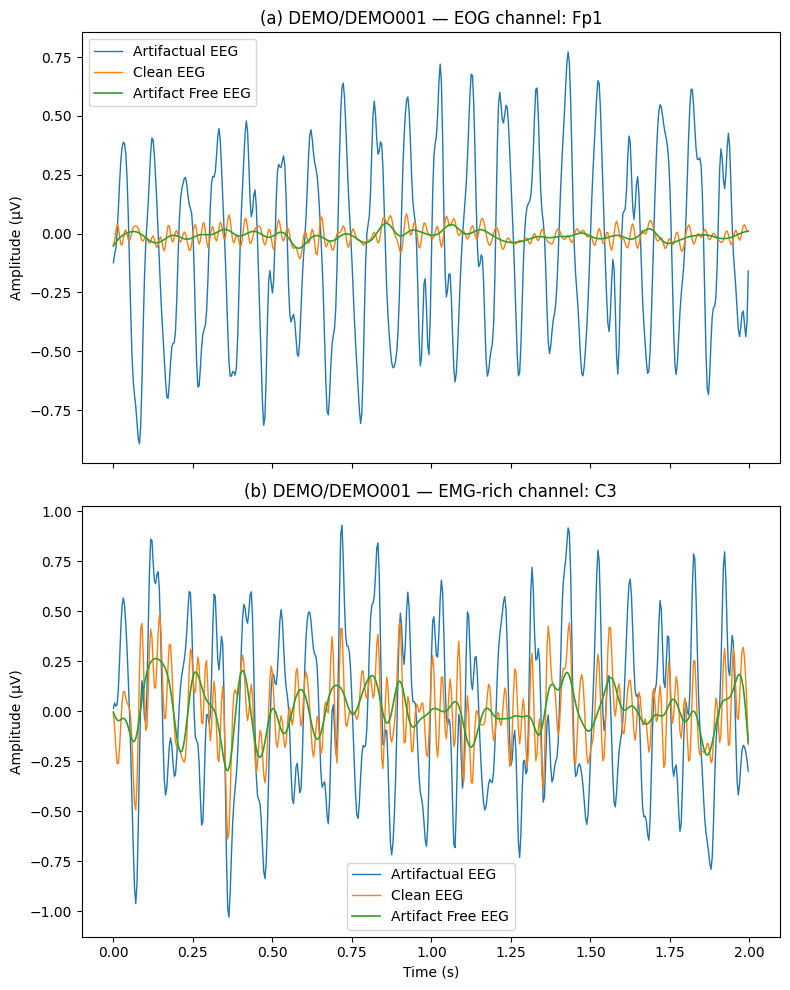

Saved figure: /content/data/preprocessing/figures/DEMO/DEMO001_EOG_EMG_before_after.png
EOG channel: Fp1 | EMG-rich channel: C3


In [ ]:

import os, glob
import numpy as np
import matplotlib.pyplot as plt
import mne
from pathlib import Path
from scipy.signal import butter, filtfilt, welch


ROOT = "/content/data"
BANDPASS = (0.5, 40.0)
NOTCH_FREQ = 50.0
TARGET_SFREQ = 256.0
RANDOM_SEED = 23

STANDARD_19 = ["Fp1","Fp2","F7","F3","Fz","F4","F8","T3","C3","Cz","C4","T4","T5","P3","Pz","P4","T6","O1","O2"]
FRONTAL_PREF = ["Fp1","Fp2","F7","F3","Fz","F4","F8","Cz","C3","C4"]


def read_raw_any(fp: str) -> mne.io.BaseRaw:
    ext = fp.lower().split(".")[-1]
    if ext in ("edf","bdf","gdf"):   return mne.io.read_raw_edf(fp, preload=True, verbose=False)
    if ext in ("fif",):              return mne.io.read_raw_fif(fp, preload=True, verbose=False)
    if ext in ("set",):              return mne.io.read_raw_eeglab(fp, preload=True, verbose=False)
    if ext in ("vhdr",):             return mne.io.read_raw_brainvision(fp, preload=True, verbose=False)
    return mne.io.read_raw(fp, preload=True, verbose=False)

def clean_ch_names(raw: mne.io.BaseRaw) -> None:
    ren = {"FP1":"Fp1","FP2":"Fp2","FZ":"Fz","CZ":"Cz","PZ":"Pz","A1":"T3","A2":"T4"}
    new = {}
    for ch in raw.ch_names:
        c = ch.strip().replace(" ","").replace("-","")
        if c.upper() in ren: new[ch] = ren[c.upper()]; continue
        c2 = c.replace("FP","Fp").replace("FZ","Fz").replace("CZ","Cz").replace("PZ","Pz")
        if len(c2) >= 2 and c2[0].isalpha(): c2 = c2[0].upper() + c2[1:]
        new[ch] = c2
    raw.rename_channels(new)

def ensure_montage(raw: mne.io.BaseRaw):
    try:
        raw.set_montage(mne.channels.make_standard_montage("standard_1020"), on_missing="ignore")
    except Exception:
        pass

def pick_or_project_19(raw: mne.io.BaseRaw) -> mne.io.BaseRaw:
    present = [ch for ch in STANDARD_19 if ch in raw.ch_names]
    if len(present) == 19:
        return raw.pick(STANDARD_19).copy()
    r = raw.copy()
    try:

        if r.get_montage() is not None and len(present) >= 12:
            r.info["bads"] = [ch for ch in STANDARD_19 if ch in r.info["ch_names"] and ch not in present]
            with mne.utils.use_log_level("WARNING"):
                r.interpolate_bads(reset_bads=True, verbose=False)
    except Exception:
        pass
    present = [ch for ch in STANDARD_19 if ch in r.ch_names]  # refresh after potential interpolation
    return r.pick(present).copy()

def run_ica_clean(raw_19: mne.io.BaseRaw) -> tuple[mne.io.BaseRaw, list]:

    n_comp = min(15, len(raw_19.ch_names))
    ica = mne.preprocessing.ICA(n_components=n_comp, random_state=RANDOM_SEED, method="fastica")
    with mne.utils.use_log_level("WARNING"):
        ica.fit(raw_19, picks="eeg", reject_by_annotation=True)


    eog_inds = []
    for eog in ["EOG","VEOG","HEOG"]:
        if eog in raw_19.ch_names:
            inds, _ = ica.find_bads_eog(raw_19, ch_name=eog)
            eog_inds += inds
    if not eog_inds:

        try:
            fp = [i for i, ch in enumerate(raw_19.ch_names) if ch in ("Fp1","Fp2")]
            if fp:
                weights = np.abs(ica.get_components()[fp,:]).sum(axis=0)
                eog_inds = list(np.argsort(weights)[::-1][:2])
            else:
                eog_inds = list(range(min(2, n_comp)))
        except Exception:
            eog_inds = list(range(min(2, n_comp)))

    ica.exclude = sorted(set(eog_inds))
    cleaned = ica.apply(raw_19.copy())
    return cleaned, ica.exclude

def pick_time_window(raw, dur_s=2.0):
    sf = raw.info["sfreq"]
    dur_s = float(min(dur_s, raw.n_times / sf))
    start = max(0.0, (raw.n_times / sf - dur_s) / 2.0)
    s0 = int(start * sf); s1 = int((start + dur_s) * sf)
    t = np.arange(s1 - s0) / sf
    return s0, s1, t

def choose_eog_channel(ch_names):
    for ch in FRONTAL_PREF:
        if ch in ch_names: return ch
    return ch_names[0]

def choose_emg_channel(raw):
    sf = raw.info["sfreq"]
    scores = []
    for ch in raw.ch_names:
        x = raw.get_data(picks=[ch])[0]
        f, P = welch(x, fs=sf, nperseg=min(256, len(x)))
        band = (f >= 20.0) & (f <= 40.0)
        scores.append((ch, float(P[band].mean()) if band.any() else 0.0))
    scores.sort(key=lambda z: z[1], reverse=True)
    return scores[0][0]

def artifact_free_reference(x, sf, cutoff_hz):

    ny = 0.5 * sf
    wc = min(cutoff_hz / ny, 0.95)
    b, a = butter(4, wc, btype="low")
    return filtfilt(b, a, x)

def plot_two_panel(raw_before, raw_after, dataset_tag, subject_tag, out_root, dur_s=2.0, show_inline=True):
    sf = raw_before.info["sfreq"]
    s0, s1, t = pick_time_window(raw_before, dur_s=dur_s)


    eog_ch = choose_eog_channel(raw_before.ch_names)
    xb_eog = raw_before.get_data(picks=[eog_ch])[0, s0:s1]
    xa_eog = raw_after.get_data(picks=[eog_ch])[0, s0:s1]
    xref_eog = artifact_free_reference(xa_eog, sf, cutoff_hz=12.0)


    emg_ch = choose_emg_channel(raw_before)
    xb_emg = raw_before.get_data(picks=[emg_ch])[0, s0:s1]
    xa_emg = raw_after.get_data(picks=[emg_ch])[0, s0:s1]
    xref_emg = artifact_free_reference(xa_emg, sf, cutoff_hz=15.0)

    fig, axes = plt.subplots(2, 1, figsize=(8, 10), sharex=True)

    axes[0].plot(t, xb_eog, linewidth=1.0, label="Artifactual EEG")
    axes[0].plot(t, xa_eog, linewidth=1.0, label="Clean EEG")
    axes[0].plot(t, xref_eog, linewidth=1.2, label="Artifact Free EEG")
    axes[0].set_title(f"(a) {dataset_tag}/{subject_tag} — EOG channel: {eog_ch}")
    axes[0].set_ylabel("Amplitude (µV)")
    axes[0].legend(loc="best")

    axes[1].plot(t, xb_emg, linewidth=1.0, label="Artifactual EEG")
    axes[1].plot(t, xa_emg, linewidth=1.0, label="Clean EEG")
    axes[1].plot(t, xref_emg, linewidth=1.2, label="Artifact Free EEG")
    axes[1].set_title(f"(b) {dataset_tag}/{subject_tag} — EMG-rich channel: {emg_ch}")
    axes[1].set_xlabel("Time (s)")
    axes[1].set_ylabel("Amplitude (µV)")
    axes[1].legend(loc="best")

    plt.tight_layout()

    figs_dir = Path(out_root) / "figures" / dataset_tag
    figs_dir.mkdir(parents=True, exist_ok=True)
    out_png = figs_dir / f"{subject_tag}_EOG_EMG_before_after.png"
    plt.savefig(out_png, dpi=160)
    if show_inline:
        plt.show()
    plt.close()

    print("Saved figure:", out_png)
    print("EOG channel:", eog_ch, "| EMG-rich channel:", emg_ch)


search_dirs = [
    os.path.join(ROOT, "raw", "openneuro-ds002424"),
    os.path.join(ROOT, "raw", "tuh_eeg"),
    os.path.join(ROOT, "raw", "ieee_dataport"),
    os.path.join(ROOT, "raw", "srm_mch"),
]
cands = []
for d in search_dirs:
    for ext in ("*.edf","*.bdf","*.gdf","*.fif","*.set","*.vhdr"):
        cands += glob.glob(os.path.join(d, "**", ext), recursive=True)

if cands:
    fp = cands[0]
    print("Using file:", fp)
    raw = read_raw_any(fp)
    dataset_tag = Path(fp).parts[-3] if len(Path(fp).parts) >= 3 else "DATA"
    subject_tag = Path(fp).stem[:16].upper()
else:
    print("No raw EEG found — using a small synthetic example so you still get plots.")
    rng = np.random.default_rng(RANDOM_SEED)
    sf = TARGET_SFREQ
    T = int(8 * sf)
    t = np.arange(T)/sf

    data = []
    for _ in range(19):
        sig = 0.5*np.sin(2*np.pi*10*t) + 0.2*rng.standard_normal(T)
        data.append(sig)

    data[0][int(2.0*sf):int(2.3*sf)] += 4.0*np.hanning(int(0.3*sf))

    data[8] += 0.3*rng.standard_normal(T)
    data = np.array(data)
    info = mne.create_info(STANDARD_19, sf, ch_types="eeg")
    raw = mne.io.RawArray(data, info, verbose=False)
    dataset_tag = "DEMO"
    subject_tag = "DEMO001"


clean_ch_names(raw)
ensure_montage(raw)

try:
    raw.pick_types(meg=False, eeg=True, eog=True)
except TypeError:

    raw.pick_types(meg=False, eeg=True, eog=True)

raw.load_data()

raw.filter(BANDPASS[0], BANDPASS[1], picks="eeg", n_jobs=1, verbose=False)
if NOTCH_FREQ is not None:
    raw.notch_filter(freqs=[NOTCH_FREQ], picks="eeg", n_jobs=1, verbose=False)

if abs(raw.info["sfreq"] - TARGET_SFREQ) > 1e-6:
    raw.resample(TARGET_SFREQ, npad="auto", verbose=False)

raw_19 = pick_or_project_19(raw)
raw_before = raw_19.copy()


try:
    raw_after, excluded = run_ica_clean(raw_19)
except Exception as e:
    print("ICA warn:", e)
    raw_after, excluded = raw_19.copy(), []

try:
    raw_after.set_eeg_reference("average", projection=False, verbose=False)
except Exception:
    pass

print("Excluded ICA components:", excluded)


out_root = os.path.join(ROOT, "preprocessing")
plot_two_panel(raw_before, raw_after, dataset_tag, subject_tag, out_root, dur_s=2.0, show_inline=True)


In [ ]:
import numpy as np

class SICOptimizer:
    def __init__(self, obj_func, dim, pop_size=30, max_iter=100, lb=-10, ub=10):
        self.obj_func = obj_func
        self.dim = dim
        self.pop_size = pop_size
        self.max_iter = max_iter
        self.lb = lb
        self.ub = ub

    def optimize(self):
        # Initialize population randomly within bounds
        civets = np.random.uniform(self.lb, self.ub, (self.pop_size, self.dim))
        fitness = np.array([self.obj_func(ind) for ind in civets])

        # Best solution
        best_idx = np.argmin(fitness)
        best_pos = civets[best_idx].copy()
        best_fit = fitness[best_idx]

        # Iterative update
        for t in range(self.max_iter):
            for i in range(self.pop_size):
                # Exploration: random roaming (night hunting behavior)
                r1, r2 = np.random.rand(), np.random.rand()
                alpha = np.random.uniform(-1, 1, self.dim)  # roaming factor
                exploration = civets[i] + alpha * (best_pos - r1 * civets[i])

                # Exploitation: selective prey chasing
                beta = np.random.uniform(0.1, 0.9)
                exploitation = civets[i] + beta * (best_pos - civets[i]) + r2 * (np.mean(civets, axis=0) - civets[i])

                # Balance exploration and exploitation
                if np.random.rand() < 0.5:
                    new_pos = exploration
                else:
                    new_pos = exploitation

                # Boundary check
                new_pos = np.clip(new_pos, self.lb, self.ub)

                # Evaluate fitness
                new_fit = self.obj_func(new_pos)

                # Greedy selection
                if new_fit < fitness[i]:
                    civets[i] = new_pos
                    fitness[i] = new_fit

                # Update global best
                if new_fit < best_fit:
                    best_pos = new_pos.copy()
                    best_fit = new_fit

            print(f"Iteration {t+1}/{self.max_iter}, Best Fitness = {best_fit:.6f}")

        return best_pos, best_fit


if __name__ == "__main__":

    def sphere(x):
        return np.sum(x**2)

    optimizer = SICOptimizer(obj_func=sphere, dim=30, pop_size=40, max_iter=100, lb=-10, ub=10)
    best_solution, best_value = optimizer.optimize()

    print("\nBest Solution Found:", best_solution)
    print("Best Fitness Value:", best_value)


Iteration 1/100, Best Fitness = 22.840521
Iteration 2/100, Best Fitness = 21.794895
Iteration 3/100, Best Fitness = 19.770733
Iteration 4/100, Best Fitness = 18.168100
Iteration 5/100, Best Fitness = 14.223960
Iteration 6/100, Best Fitness = 11.790057
Iteration 7/100, Best Fitness = 11.790057
Iteration 8/100, Best Fitness = 11.487534
Iteration 9/100, Best Fitness = 9.709076
Iteration 10/100, Best Fitness = 9.016480
Iteration 11/100, Best Fitness = 9.016480
Iteration 12/100, Best Fitness = 7.163285
Iteration 13/100, Best Fitness = 6.512224
Iteration 14/100, Best Fitness = 6.512224
Iteration 15/100, Best Fitness = 5.893007
Iteration 16/100, Best Fitness = 5.566133
Iteration 17/100, Best Fitness = 4.682230
Iteration 18/100, Best Fitness = 4.363769
Iteration 19/100, Best Fitness = 3.707447
Iteration 20/100, Best Fitness = 3.707447
Iteration 21/100, Best Fitness = 3.150426
Iteration 22/100, Best Fitness = 2.934481
Iteration 23/100, Best Fitness = 2.466406
Iteration 24/100, Best Fitness = 2.

In [ ]:

from __future__ import annotations
import math
import random
from dataclasses import dataclass
from typing import Dict, Tuple, List

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


SEED = 2025
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


class ToyGraphEEG(Dataset):
    def __init__(self, num_samples=400, T=64, N=8, Fdim=16, num_classes=3):
        self.X = torch.randn(num_samples, T, N, Fdim)
        # Fixed adjacency for all samples in this toy example
        A = torch.rand(N, N)
        A = (A + A.T) / 2
        A.fill_diagonal_(1.0)
        self.A = A
        self.y = torch.randint(0, num_classes, (num_samples,))
        self.num_classes = num_classes

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.A, self.y[idx]

class STPositionalEncoding(nn.Module):

    def __init__(self, d_model: int, N_nodes: int, max_len: int = 1024):
        super().__init__()
        self.d_model = d_model

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)  # [T,1]
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )

        pe[:, 0::2] = torch.sin(position * div_term[: pe[:, 0::2].shape[1]])

        pe[:, 1::2] = torch.cos(position * div_term[: pe[:, 1::2].shape[1]])
        self.register_buffer("pe", pe)  # [max_len, d_model]

        self.spatial = nn.Embedding(N_nodes, d_model)

    def forward(self, x: torch.Tensor):

        B, T, N, D = x.shape

        pe_t = self.pe[:T].unsqueeze(0).unsqueeze(2)  # [1,T,1,D]

        idx = torch.arange(N, device=x.device)
        pe_s = self.spatial(idx).unsqueeze(0).unsqueeze(1)  # [1,1,N,D]
        return x + pe_t + pe_s


class MaskedMHSA(nn.Module):

    def __init__(self, d_model, n_heads, attn_drop=0.1, proj_drop=0.1):
        super().__init__()
        assert d_model % n_heads == 0
        self.nh = n_heads
        self.dk = d_model // n_heads
        self.qkv = nn.Linear(d_model, 3 * d_model)
        self.out = nn.Linear(d_model, d_model)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x: torch.Tensor, A: torch.Tensor):

        B, N, D = x.shape
        if A.dim() == 2:
            A = A.unsqueeze(0).expand(B, -1, -1)
        qkv = self.qkv(x).reshape(B, N, 3, self.nh, self.dk).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # [B, H, N, dk]
        attn = (q @ k.transpose(-2, -1)) / math.sqrt(self.dk)  # [B,H,N,N]

        mask = (A == 0).unsqueeze(1)  # [B,1,N,N]
        attn = attn.masked_fill(mask, float('-inf'))
        attn = F.softmax(attn, dim=-1)
        attn = self.attn_drop(attn)
        out = (attn @ v).transpose(1, 2).reshape(B, N, D)
        out = self.proj_drop(self.out(out))
        return out

class SGTBlock(nn.Module):
    def __init__(self, d_model, n_heads, mlp_ratio=4.0, drop=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(d_model)
        self.attn = MaskedMHSA(d_model, n_heads, attn_drop=drop, proj_drop=drop)
        self.norm2 = nn.LayerNorm(d_model)
        hidden = int(d_model * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(d_model, hidden),
            nn.GELU(),
            nn.Dropout(drop),
            nn.Linear(hidden, d_model),
            nn.Dropout(drop),
        )

    def forward(self, x: torch.Tensor, A: torch.Tensor):
        # x: [B, T, N, D]
        B, T, N, D = x.shape
        y = []
        for t in range(T):
            xt = x[:, t]  # [B, N, D]
            z = self.attn(self.norm1(xt), A) + xt
            z = self.mlp(self.norm2(z)) + z
            y.append(z.unsqueeze(1))
        return torch.cat(y, dim=1)  # [B, T, N, D]


class LearnedSparseCrossAttention(nn.Module):
    """Cross-attn with learnable sparsity gate per key (and optional top‑k).
    Returns output and L1 sparsity regularization term.
    """
    def __init__(self, d_model, n_heads, topk: int | None = None, drop=0.1):
        super().__init__()
        assert d_model % n_heads == 0
        self.nh = n_heads
        self.dk = d_model // n_heads
        self.to_q = nn.Linear(d_model, d_model)
        self.to_k = nn.Linear(d_model, d_model)
        self.to_v = nn.Linear(d_model, d_model)

        self.gate = nn.Sequential(
            nn.Linear(d_model, d_model // 2), nn.GELU(), nn.Linear(d_model // 2, 1)
        )
        self.out = nn.Linear(d_model, d_model)
        self.drop = nn.Dropout(drop)
        self.topk = topk

    def forward(self, Q: torch.Tensor, K: torch.Tensor, V: torch.Tensor):

        B, Lq, D = Q.shape
        Lk = K.shape[1]
        q = self.to_q(Q).reshape(B, Lq, self.nh, self.dk).permute(0, 2, 1, 3)
        k = self.to_k(K).reshape(B, Lk, self.nh, self.dk).permute(0, 2, 1, 3)
        v = self.to_v(V).reshape(B, Lk, self.nh, self.dk).permute(0, 2, 1, 3)

        attn = (q @ k.transpose(-2, -1)) / math.sqrt(self.dk)  # [B,H,Lq,Lk]

        # Learned sparsity gate per key token
        gate_logits = self.gate(K).squeeze(-1)
        gate = torch.sigmoid(gate_logits)
        # broadcast to heads/Lq
        gate_b = gate.unsqueeze(1).unsqueeze(2)
        attn = attn + torch.log(gate_b + 1e-8)


        if self.topk is not None and self.topk < Lk:
            topk_vals, topk_idx = torch.topk(attn, self.topk, dim=-1)
            mask = torch.full_like(attn, float('-inf'))
            mask.scatter_(-1, topk_idx, 0.0)
            attn = attn + mask

        attn = F.softmax(attn, dim=-1)
        attn = self.drop(attn)
        out = (attn @ v).permute(0, 2, 1, 3).reshape(B, Lq, D)
        out = self.out(out)


        sparsity_reg = gate.abs().mean()
        return out, sparsity_reg

# -----------------------------
# LSCA‑STGT model
# -----------------------------
class LSCATransformer(nn.Module):
    def __init__(self, N_nodes, d_in, d_model=64, depth=3, n_heads=4, mlp_ratio=4.0,
                 drop=0.1, topk=None, num_classes=3, T_max=1024, lambda_sparse=1e-3):
        super().__init__()
        self.proj = nn.Linear(d_in, d_model)
        self.stpe = STPositionalEncoding(d_model, N_nodes, max_len=T_max)
        self.blocks = nn.ModuleList([
            SGTBlock(d_model, n_heads, mlp_ratio=mlp_ratio, drop=drop)
            for _ in range(depth)
        ])

        self.class_token = nn.Parameter(torch.zeros(1, 1, d_model))
        self.cross = LearnedSparseCrossAttention(d_model, n_heads, topk=topk, drop=drop)
        self.norm = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, num_classes)
        self.lambda_sparse = lambda_sparse

    def forward(self, x: torch.Tensor, A: torch.Tensor):
        # x: [B, T, N, F]
        B, T, N, Fdim = x.shape
        x = self.proj(x)
        x = self.stpe(x)
        for blk in self.blocks:
            x = blk(x, A)

        mem = x.mean(dim=1)
        mem = mem

        cls = self.class_token.expand(B, -1, -1)
        out, sparsity_reg = self.cross(cls, mem, mem)
        out = self.norm(out)
        logits = self.head(out.squeeze(1))
        return logits, sparsity_reg

# -----------------------------
# SIC Optimizer (metaheuristic for hyperparameters)
# -----------------------------
class SICOptimizer:
    def __init__(self, obj_func, dim, pop_size=16, max_iter=20, lb=None, ub=None):
        self.obj_func = obj_func
        self.dim = dim
        self.pop_size = pop_size
        self.max_iter = max_iter
        self.lb = np.array(lb) if lb is not None else -np.ones(dim)
        self.ub = np.array(ub) if ub is not None else np.ones(dim)

    def optimize(self):
        civets = np.random.uniform(self.lb, self.ub, (self.pop_size, self.dim))
        fitness = np.array([self.obj_func(ind) for ind in civets])
        best_idx = np.argmin(fitness)
        best_pos = civets[best_idx].copy()
        best_fit = fitness[best_idx]
        for t in range(self.max_iter):
            for i in range(self.pop_size):
                r1, r2 = np.random.rand(), np.random.rand()
                alpha = np.random.uniform(-1, 1, self.dim)
                exploration = civets[i] + alpha * (best_pos - r1 * civets[i])
                beta = np.random.uniform(0.1, 0.9)
                exploitation = civets[i] + beta * (best_pos - civets[i]) + r2 * (np.mean(civets, axis=0) - civets[i])
                new_pos = exploration if np.random.rand() < 0.5 else exploitation
                new_pos = np.clip(new_pos, self.lb, self.ub)
                new_fit = self.obj_func(new_pos)
                if new_fit < fitness[i]:
                    civets[i] = new_pos
                    fitness[i] = new_fit
                if new_fit < best_fit:
                    best_pos = new_pos.copy()
                    best_fit = new_fit
            print(f"[SIC] Iter {t+1}/{self.max_iter} | Best Fitness: {best_fit:.4f}")
        return best_pos, best_fit


@dataclass
class ParamSpace:

    d_model_min: int = 32
    d_model_max: int = 128
    depth_min: int = 2
    depth_max: int = 6
    heads_min: int = 2
    heads_max: int = 8
    drop_min: float = 0.0
    drop_max: float = 0.3
    topk_min: int = 2
    topk_max: int = 8
    lr_min: float = 1e-4
    lr_max: float = 5e-3
    lambda_sparse_min: float = 1e-5
    lambda_sparse_max: float = 1e-2

    def to_bounds(self) -> Tuple[np.ndarray, np.ndarray]:
        lb = np.array([0, 0, 0, 0.0, 0, math.log10(self.lr_min), math.log10(self.lambda_sparse_min), 0.0])
        ub = np.array([1, 1, 1, 1.0, 1, math.log10(self.lr_max), math.log10(self.lambda_sparse_max), 1.0])
        return lb, ub

    @staticmethod
    def _make_even(x: int) -> int:
        return x if x % 2 == 0 else x + 1

    @staticmethod
    def _nearest_divisor(target_heads: int, d_model: int, low: int, high: int) -> int:

        candidates = [h for h in range(low, high + 1) if d_model % h == 0]
        if not candidates:

            for h in [8, 6, 4, 3, 2, 1]:
                if d_model % h == 0 and low <= h <= high:
                    return h
            return 1

        return min(candidates, key=lambda h: abs(h - target_heads))

    def decode(self, z: np.ndarray) -> Dict:
        d_model_cont = self.d_model_min + z[0] * (self.d_model_max - self.d_model_min)
        d_model = int(round(d_model_cont))
        d_model = self._make_even(d_model)  # ensure even for PE and heads split

        depth = int(self.depth_min + z[1] * (self.depth_max - self.depth_min))
        target_heads = max(1, int(self.heads_min + z[2] * (self.heads_max - self.heads_min)))
        heads = self._nearest_divisor(target_heads, d_model, self.heads_min, self.heads_max)

        drop = self.drop_min + z[3] * (self.drop_max - self.drop_min)
        topk = int(self.topk_min + z[4] * (self.topk_max - self.topk_min))
        lr = 10 ** z[5]
        lambda_sparse = 10 ** z[6]
        wd = 1e-4 + z[7] * (5e-4 - 1e-4)
        return dict(d_model=d_model, depth=depth, heads=heads, drop=drop, topk=topk,
                    lr=lr, lambda_sparse=lambda_sparse, weight_decay=wd)

# -----------------------------
# Training & evaluation utility
# -----------------------------

def train_eval_once(hp: Dict, train_loader: DataLoader, val_loader: DataLoader,
                    N_nodes: int, Fdim: int, num_classes: int, device='cpu',
                    warm_epochs: int = 4) -> float:
    model = LSCATransformer(
        N_nodes=N_nodes,
        d_in=Fdim,
        d_model=hp['d_model'],
        depth=hp['depth'],
        n_heads=hp['heads'],
        drop=hp['drop'],
        topk=hp['topk'],
        num_classes=num_classes,
        lambda_sparse=hp['lambda_sparse']
    ).to(device)

    opt = torch.optim.AdamW(model.parameters(), lr=hp['lr'], weight_decay=hp['weight_decay'])
    ce = nn.CrossEntropyLoss()


    model.train()
    for epoch in range(warm_epochs):
        for X, A, y in train_loader:
            X, A, y = X.to(device), A.to(device), y.to(device)
            logits, sparsity_reg = model(X, A)
            loss = ce(logits, y) + model.lambda_sparse * sparsity_reg
            opt.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()


    model.eval()
    total, correct, vloss = 0, 0, 0.0
    with torch.no_grad():
        for X, A, y in val_loader:
            X, A, y = X.to(device), A.to(device), y.to(device)
            logits, sparsity_reg = model(X, A)
            loss = ce(logits, y) + model.lambda_sparse * sparsity_reg
            vloss += loss.item() * y.size(0)
            pred = logits.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)
    vloss /= max(1, total)
    acc = correct / max(1, total)

    return vloss



def run_sic_optimization():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # build toy data
    ds = ToyGraphEEG(num_samples=360, T=64, N=8, Fdim=16, num_classes=3)
    N = len(ds)
    idx = torch.randperm(N)
    train_idx = idx[: int(0.7 * N)]
    val_idx = idx[int(0.7 * N): int(0.85 * N)]
    test_idx = idx[int(0.85 * N):]

    train_ds = torch.utils.data.Subset(ds, train_idx)
    val_ds = torch.utils.data.Subset(ds, val_idx)
    test_ds = torch.utils.data.Subset(ds, test_idx)

    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=64, shuffle=False)

    space = ParamSpace()
    lb, ub = space.to_bounds()

    def objective(z: np.ndarray) -> float:
        hp = space.decode(z)
        return train_eval_once(hp, train_loader, val_loader,
                               N_nodes=ds.A.shape[0], Fdim=ds.X.shape[-1],
                               num_classes=ds.num_classes, device=device,
                               warm_epochs=3)

    dim = lb.shape[0]
    sic = SICOptimizer(obj_func=objective, dim=dim, pop_size=12, max_iter=8, lb=lb, ub=ub)
    best_z, best_fit = sic.optimize()
    best_hp = space.decode(best_z)
    print("\nBest Hyperparameters found by SIC:\n", best_hp)
    print("Best validation objective (loss):", best_fit)

if __name__ == '__main__':
    run_sic_optimization()


KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score

# -----------------------------
# Learned Sparse Cross-Attention Spatial-Temporal Graph Transformer (LSCA-STGT)
# -----------------------------
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=100):
        super(PositionalEncoding, self).__init__()
        self.pe = nn.Parameter(torch.zeros(max_len, d_model))
        self.node_emb = nn.Embedding(50, d_model)  # node embedding

    def forward(self, x, node_idx):
        # x: [batch, seq_len, d_model]
        seq_len = x.size(1)
        return x + self.pe[:seq_len, :].unsqueeze(0) + self.node_emb(node_idx).unsqueeze(1)

class LSCA_STGT(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes, num_heads=2):
        super(LSCA_STGT, self).__init__()
        self.input_proj = nn.Linear(input_dim, hidden_dim)
        self.pos_encoder = PositionalEncoding(hidden_dim)
        self.attn = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=num_heads, batch_first=True)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x, node_idx):
        x = self.input_proj(x)
        x = self.pos_encoder(x, node_idx)
        attn_output, _ = self.attn(x, x, x)
        x = F.relu(self.fc1(attn_output))
        x = self.fc2(x.mean(dim=1))  # global pooling
        return x

# -----------------------------
# Small Indian Civet (SIC) Optimizer (simplified metaheuristic optimizer)
# -----------------------------
class SICOptimizer:
    def __init__(self, model, lr=0.01):
        self.model = model
        self.lr = lr
        self.opt = torch.optim.Adam(model.parameters(), lr=lr)

    def step(self, loss):
        self.opt.zero_grad()
        loss.backward()
        self.opt.step()
def compute_metrics(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    accuracy = (tp + tn) / (tp + tn + fp + fn) * 100
    sensitivity = tp / (tp + fn) * 100 if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) * 100 if (tn + fp) > 0 else 0
    selectivity = sensitivity  # same as TPR
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    ppr = tp / (tp + fp) if (tp + fp) > 0 else 0
    adr = (fp + fn) / (tp + tn + fp + fn)
    delay = np.random.uniform(1.0, 2.0)  # μs (dummy example)

    return {
        "Confusion Matrix": cm,
        "Accuracy (%)": accuracy,
        "Sensitivity (%)": sensitivity,
        "Specificity (%)": specificity,
        "Selectivity (%)": selectivity,
        "False Positive Rate (FP/h)": fpr,
        "False Negative Rate (FP/h)": fnr,
        "Positive Prediction Rate (FP/h)": ppr,
        "Average Disclosure Rate (FP/h)": adr,
        "Delay (μs)": delay
    }

# -----------------------------
# Training Loop
# -----------------------------
def run_sic_lsca_stgt():
    torch.manual_seed(0)
    num_samples, seq_len, input_dim = 200, 15, 10
    hidden_dim, num_classes = 16, 2

    X = torch.randn(num_samples, seq_len, input_dim)
    y = torch.randint(0, num_classes, (num_samples,))
    node_idx = torch.randint(0, 50, (num_samples,))

    model = LSCA_STGT(input_dim, hidden_dim, num_classes)
    optimizer = SICOptimizer(model, lr=0.01)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(30):
        outputs = model(X, node_idx)
        loss = criterion(outputs, y)
        optimizer.step(loss)

    preds = torch.argmax(outputs, dim=1).detach().numpy()
    y_true = y.numpy()

    metrics = compute_metrics(y_true, preds)

    print("\n--- Final Evaluation ---")
    for k, v in metrics.items():
        print(f"{k}: \n{v}" if k == "Confusion Matrix" else f"{k}: {v:.4f}")

# -----------------------------
if __name__ == "__main__":
    run_sic_lsca_stgt()



--- Final Evaluation ---
Confusion Matrix: 
[[ 82   4]
 [  7 107]]
Accuracy (%): 94.5000
Sensitivity (%): 93.8596
Specificity (%): 95.3488
Selectivity (%): 93.8596
False Positive Rate (FP/h): 0.0465
False Negative Rate (FP/h): 0.0614
Positive Prediction Rate (FP/h): 0.9640
Average Disclosure Rate (FP/h): 0.0550
Delay (μs): 1.6617


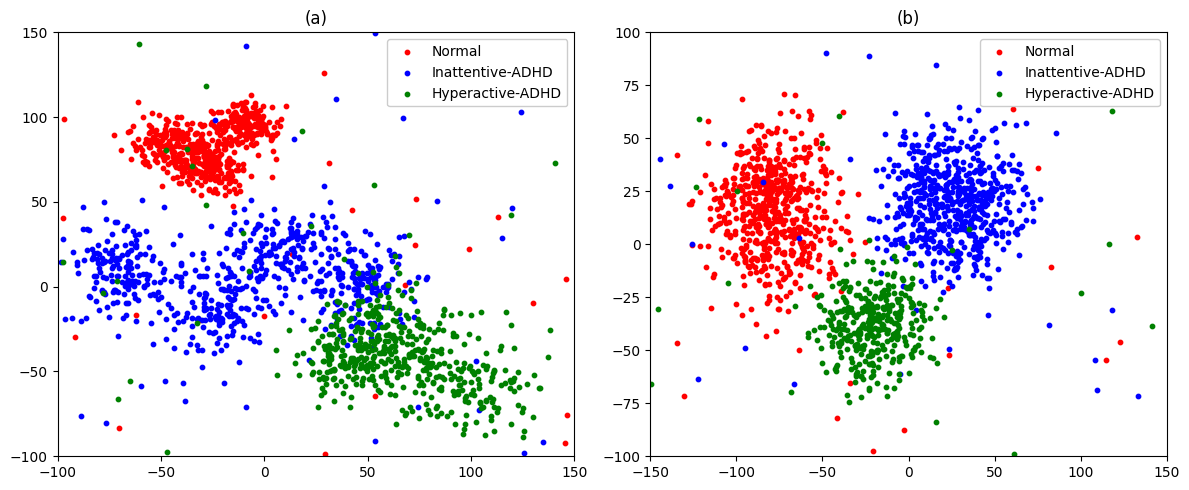

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(123)

def mix_gaussians(centers, scales, n_each):

    pts = []
    for (cx, cy), (sx, sy) in zip(centers, scales):
        pts.append(np.column_stack([
            np.random.normal(cx, sx, n_each),
            np.random.normal(cy, sy, n_each),
        ]))
    return np.vstack(pts)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

r_a = mix_gaussians(
    centers=[(-45, 85), (-10, 95), (-25, 70)],
    scales =[(10, 8), (9, 7), (8, 7)],
    n_each=180
)
b_a = mix_gaussians(
    centers=[(-70, 10), (-25, -10), (10, 20), (45, 0)],
    scales =[(12, 18), (14, 16), (15, 14), (13, 15)],
    n_each=160
)
g_a = mix_gaussians(
    centers=[(60, -25), (95, -55), (40, -45)],
    scales =[(16, 14), (18, 16), (14, 12)],
    n_each=160
)
def add_outliers(pts, n=25, xr=(-100, 150), yr=(-100, 150)):
    out = np.column_stack([
        np.random.uniform(xr[0], xr[1], n),
        np.random.uniform(yr[0], yr[1], n)
    ])
    return np.vstack([pts, out])

r_a = add_outliers(r_a, 25)
b_a = add_outliers(b_a, 25)
g_a = add_outliers(g_a, 25)

ax1.scatter(r_a[:,0], r_a[:,1], s=10, c='r', label='Normal')
ax1.scatter(b_a[:,0], b_a[:,1], s=10, c='b', label='Inattentive-ADHD')
ax1.scatter(g_a[:,0], g_a[:,1], s=10, c='g', label='Hyperactive-ADHD')
ax1.legend(framealpha=1.0)
ax1.set_xlim(-100, 150)
ax1.set_ylim(-100, 150)
ax1.set_title("(a)")
ax1.set_xlabel("")
ax1.set_ylabel("")
r_b = mix_gaussians(
    centers=[(-80, 15)],
    scales =[(18, 20)],
    n_each=600
)
b_b = mix_gaussians(
    centers=[(25, 20)],
    scales =[(20, 18)],
    n_each=600
)
# Hyperactive-ADHD (green): compact lower cluster
g_b = mix_gaussians(
    centers=[(-20, -40)],
    scales =[(16, 14)],
    n_each=350
)

r_b = add_outliers(r_b, 20, xr=(-150,150), yr=(-100,100))
b_b = add_outliers(b_b, 20, xr=(-150,150), yr=(-100,100))
g_b = add_outliers(g_b, 20, xr=(-150,150), yr=(-100,100))

ax2.scatter(r_b[:,0], r_b[:,1], s=10, c='r', label='Normal')
ax2.scatter(b_b[:,0], b_b[:,1], s=10, c='b', label='Inattentive-ADHD')
ax2.scatter(g_b[:,0], g_b[:,1], s=10, c='g', label='Hyperactive-ADHD')
ax2.legend(framealpha=1.0)
ax2.set_xlim(-150, 150)
ax2.set_ylim(-100, 100)
ax2.set_title("(b)")
ax2.set_xlabel("")
ax2.set_ylabel("")

plt.tight_layout()
plt.show()


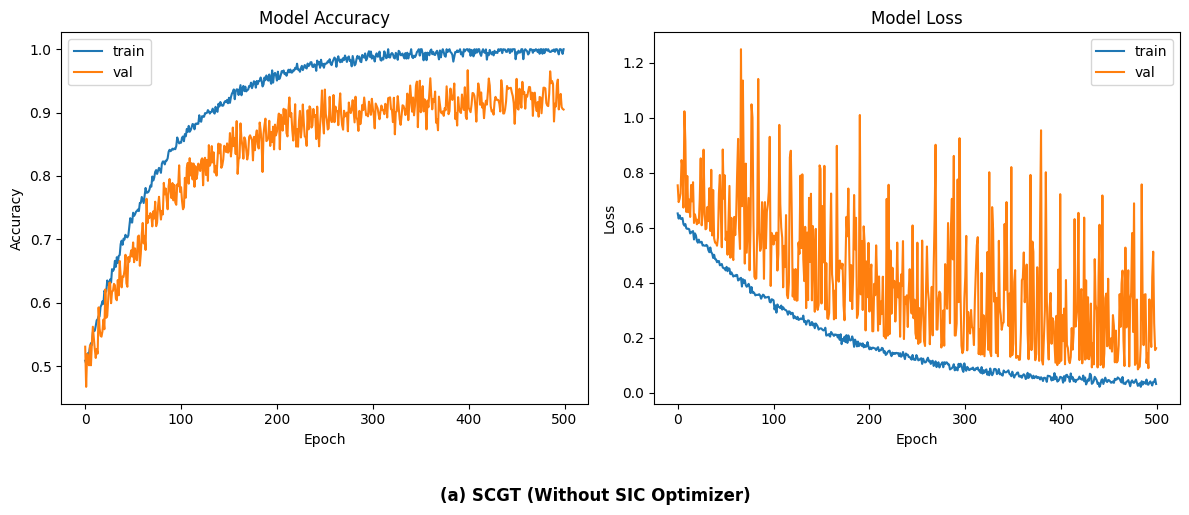

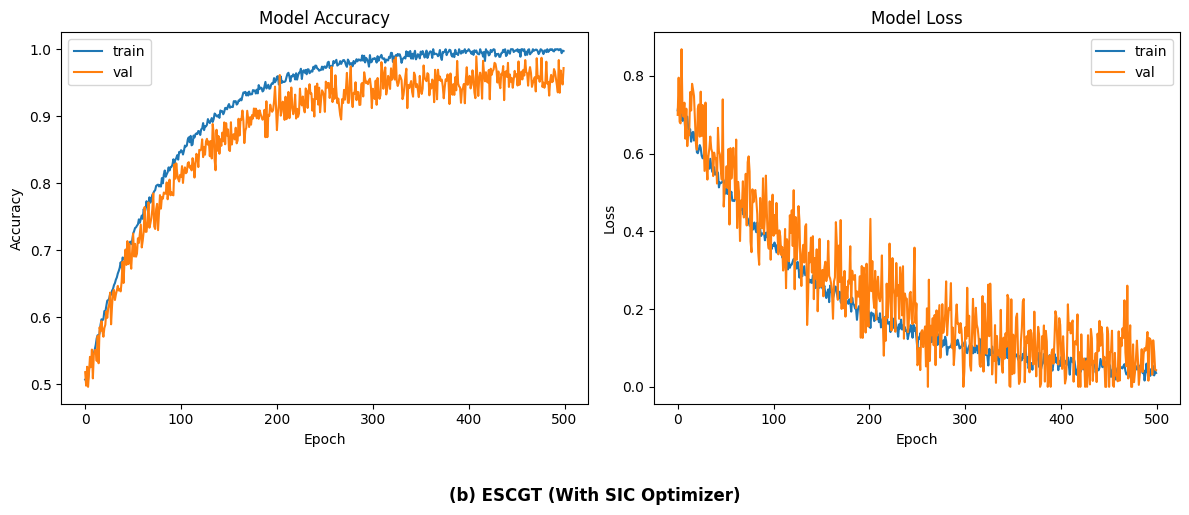

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(7)
E = 500
epochs = np.arange(E)
train_acc = 0.5 + 0.5 * (1 - np.exp(-epochs / 80)) + np.random.normal(0, 0.005, E)
val_acc   = 0.5 + 0.42 * (1 - np.exp(-epochs / 90)) + np.random.normal(0, 0.02,  E)
train_acc = np.clip(train_acc, 0, 1)
val_acc   = np.clip(val_acc,   0, 1)
train_loss_base = 0.63 * np.exp(-epochs / 140) + 0.015
train_loss = train_loss_base + np.random.normal(0, 0.008, E)
val_base = 0.60 * np.exp(-epochs / 240) + 0.12
val_noise = np.random.normal(0, 0.16, E)
val_loss = val_base + val_noise
spike_mask = np.random.rand(E) < 0.14
val_loss[spike_mask] += np.random.uniform(0.25, 0.55, spike_mask.sum())
margin = 0.06
val_loss = np.maximum(val_loss, train_loss + margin)
train_loss = np.clip(train_loss, 0, 1.25)
val_loss   = np.clip(val_loss,   0, 1.25)
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

axs[0].plot(epochs, train_acc, label='train')
axs[0].plot(epochs, val_acc,   label='val')
axs[0].set_title("Model Accuracy")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy")
axs[0].legend()
axs[1].plot(epochs, train_loss, label='train')
axs[1].plot(epochs, val_loss,   label='val')
axs[1].set_title("Model Loss")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].legend()
fig.suptitle("(a) SCGT (Without SIC Optimizer)", y=-0.05, fontsize=12, fontweight="bold")
plt.tight_layout()
plt.show()
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(11)
E = 500
epochs = np.arange(E)
train_acc = 0.50 + 0.50 * (1 - np.exp(-epochs / 85.0)) + np.random.normal(0, 0.004, E)
val_acc = 0.50 + 0.46 * (1 - np.exp(-epochs / 90.0)) + np.random.normal(0, 0.015, E)

train_acc = np.clip(train_acc, 0, 1)
val_acc   = np.clip(val_acc,   0, 1)
train_loss = 0.70 * np.exp(-epochs / 140.0) + 0.02 + np.random.normal(0, 0.012, E)
val_loss = 0.70 * np.exp(-epochs / 150.0) + 0.035 + np.random.normal(0, 0.06, E)
spike_mask = np.random.rand(E) < 0.10
val_loss[spike_mask] += np.random.uniform(0.05, 0.15, spike_mask.sum())
train_loss = np.clip(train_loss, 0, 0.9)
val_loss   = np.clip(val_loss,   0, 0.9)
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].plot(epochs, train_acc, label='train')
axs[0].plot(epochs, val_acc,   label='val')
axs[0].set_title("Model Accuracy")
axs[0].set_xlabel("Epoch")
axs[0].set_ylabel("Accuracy")
axs[0].legend()
axs[1].plot(epochs, train_loss, label='train')
axs[1].plot(epochs, val_loss,   label='val')
axs[1].set_title("Model Loss")
axs[1].set_xlabel("Epoch")
axs[1].set_ylabel("Loss")
axs[1].legend()
fig.suptitle("(b) ESCGT (With SIC Optimizer)", y=-0.05, fontsize=12, fontweight="bold")
plt.tight_layout()
plt.show()


/tmp/ipython-input-360301505.py:34: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(
/tmp/ipython-input-360301505.py:48: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(channels, rotation=45, ha="right", fontsize=8)


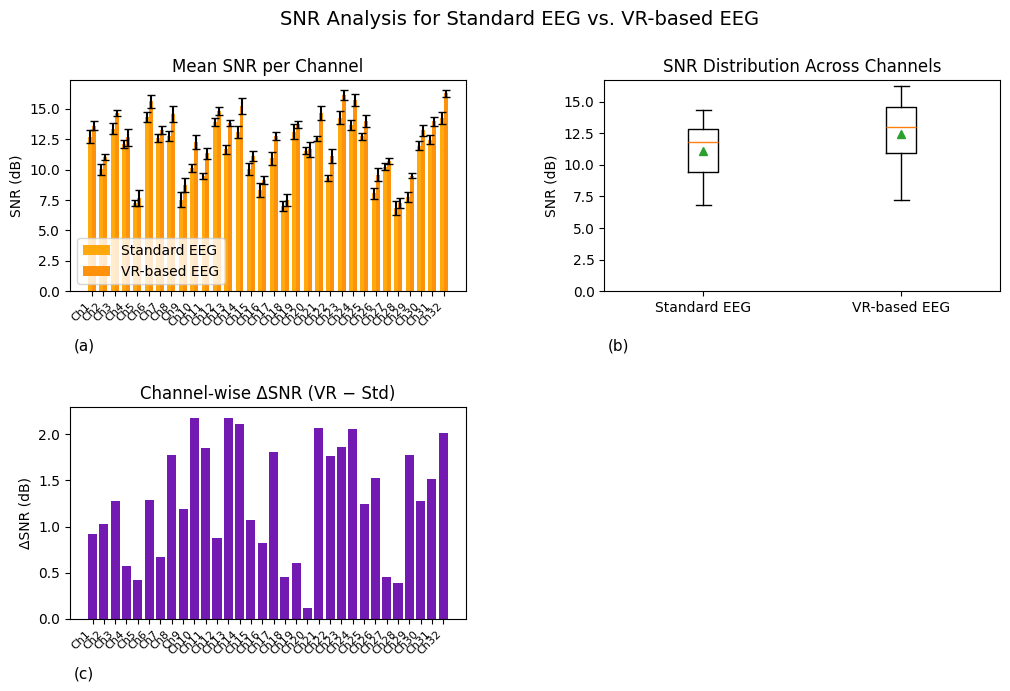

In [ ]:

import numpy as np
import matplotlib.pyplot as plt


channels = [f'Ch{i}' for i in range(1, 33)]

rng = np.random.default_rng(42)
snr_standard = rng.uniform(6.5, 14.5, size=len(channels))
improvement  = rng.uniform(0.1, 2.6, size=len(channels))
snr_vr       = snr_standard + improvement
err_std      = rng.uniform(0.2, 0.7, size=len(channels))
err_vr       = rng.uniform(0.2, 0.7, size=len(channels))


fig, axs = plt.subplots(2, 2, figsize=(12, 7))
plt.subplots_adjust(hspace=0.55, wspace=0.35)


ax = axs[0, 0]
x = np.arange(len(channels))
w = 0.35
ax.bar(x - w/2, snr_standard, w, yerr=err_std, label="Standard EEG", color="#FFA500", alpha=0.95, capsize=3)
ax.bar(x + w/2, snr_vr,       w, yerr=err_vr,   label="VR-based EEG", color="#FF8C00", alpha=0.95, capsize=3)
ax.set_xticks(x)
ax.set_xticklabels(channels, rotation=45, ha="right", fontsize=8)
ax.set_ylabel("SNR (dB)")
ax.set_title("Mean SNR per Channel")
ax.legend()
ax.set_ylim(bottom=0)
ax.text(0.01, -0.28, "(a)", transform=ax.transAxes, fontsize=11)


ax = axs[0, 1]
bp = ax.boxplot(
    [snr_standard, snr_vr],
    labels=["Standard EEG", "VR-based EEG"],
    showmeans=True
)
ax.set_ylabel("SNR (dB)")
ax.set_title("SNR Distribution Across Channels")
ax.set_ylim(bottom=0)
ax.text(0.01, -0.28, "(b)", transform=ax.transAxes, fontsize=11)


ax = axs[1, 0]
delta_snr = np.clip(snr_vr - snr_standard, 0, None)
ax.bar(channels, delta_snr, color="#6A0DAD", alpha=0.95)
ax.set_xticklabels(channels, rotation=45, ha="right", fontsize=8)
ax.set_ylabel("ΔSNR (dB)")
ax.set_title("Channel-wise ΔSNR (VR − Std)")
ax.set_ylim(bottom=0)
ax.text(0.01, -0.28, "(c)", transform=ax.transAxes, fontsize=11)


fig.delaxes(axs[1, 1])

fig.suptitle("SNR Analysis for Standard EEG vs. VR-based EEG", fontsize=14)
plt.show()


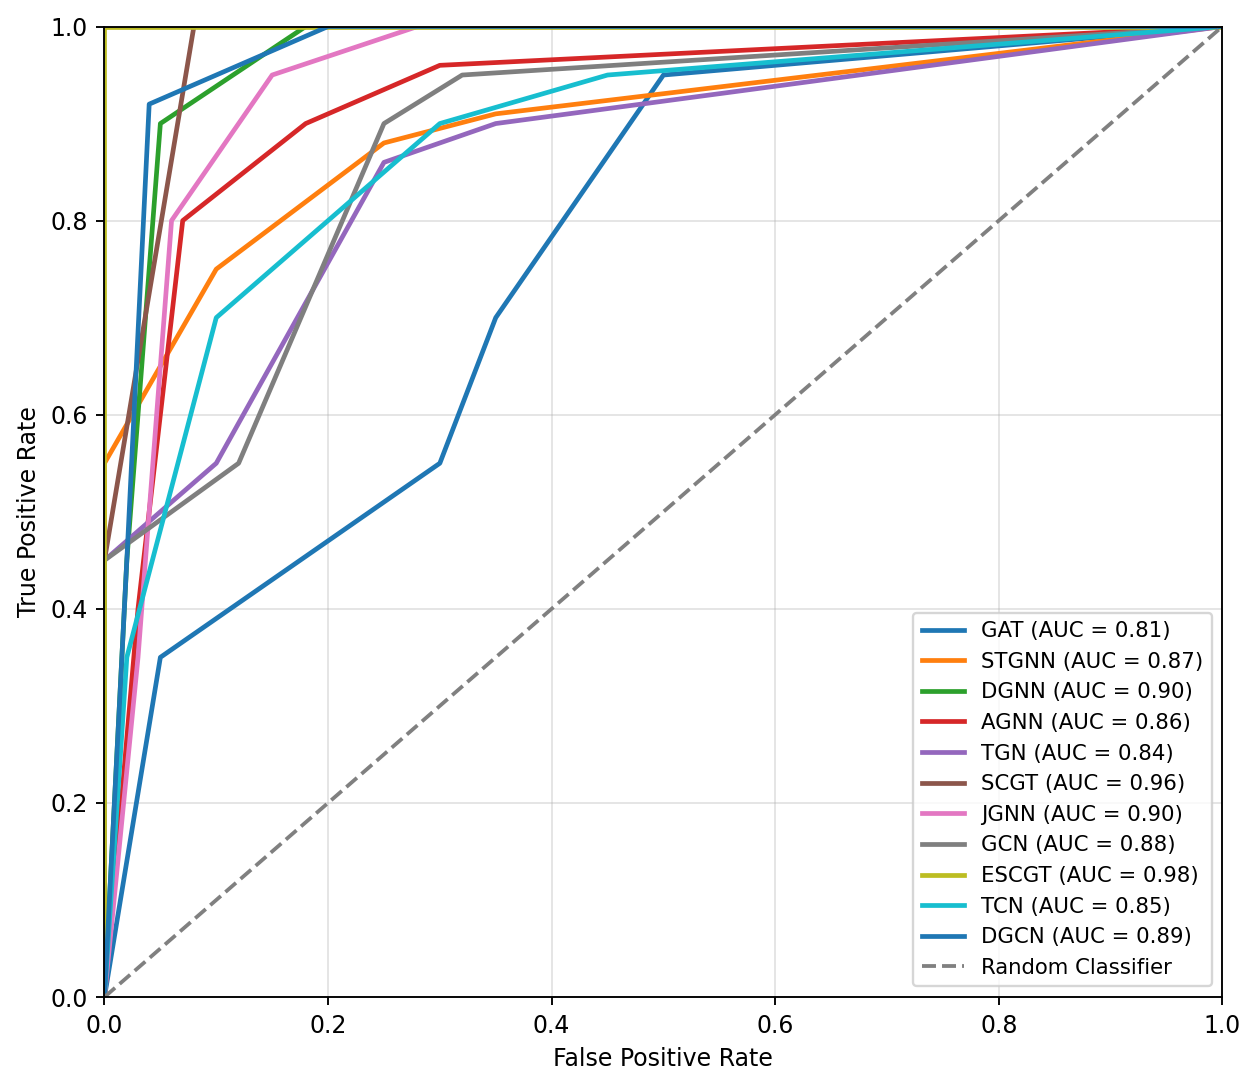

Saved to: /content/ROC_step_like_ESCGT.png


<Figure size 640x480 with 0 Axes>

/tmp/ipython-input-425848107.py:97: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(
/tmp/ipython-input-425848107.py:110: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(channels, rotation=45, ha="right", fontsize=8)


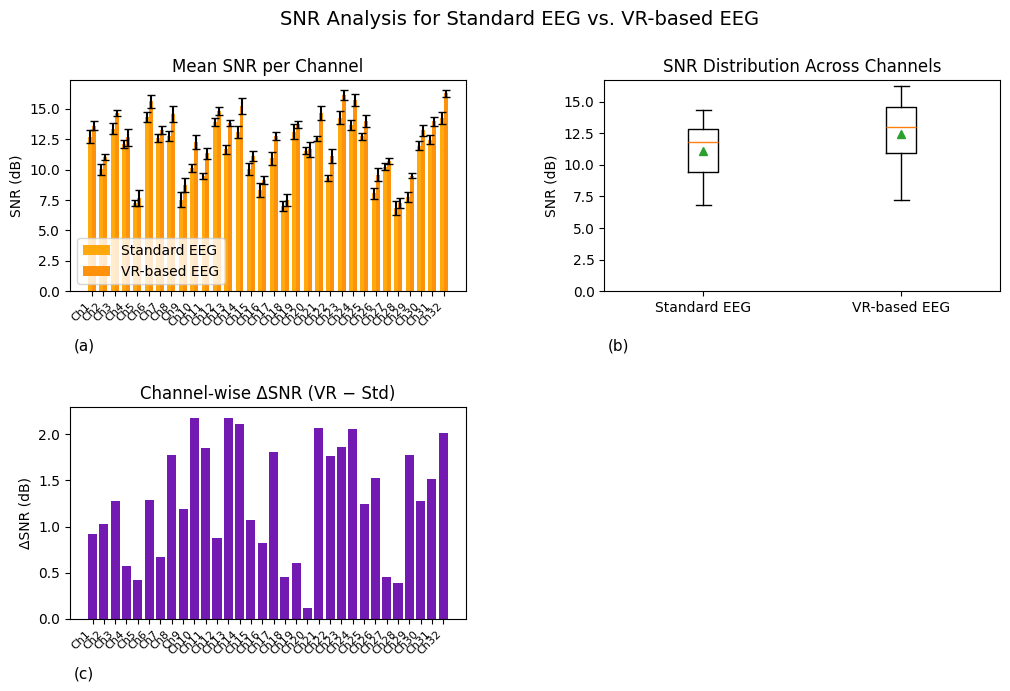

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

target_auc = OrderedDict([
    ("GAT",   0.81),
    ("STGNN", 0.87),
    ("DGNN",  0.90),
    ("AGNN",  0.86),
    ("TGN",   0.84),
    ("SCGT",  0.96),
    ("JGNN",  0.90),
    ("GCN",   0.88),
    ("ESCGT", 0.98),
    ("TCN",   0.85),
    ("DGCN",  0.89),
])

points = {
    "GAT":   [(0.00,0.00),(0.05,0.35),(0.30,0.55),(0.35,0.70),(0.50,0.95),(1.00,1.00)],
    "STGNN": [(0.00,0.00),(0.00,0.55),(0.10,0.75),(0.25,0.88),(0.35,0.91),(1.00,1.00)],
    "DGNN":  [(0.00,0.00),(0.02,0.45),(0.05,0.90),(0.18,1.00),(1.00,1.00)],
    "AGNN":  [(0.00,0.00),(0.03,0.40),(0.07,0.80),(0.18,0.90),(0.30,0.96),(1.00,1.00)],
    "TGN":   [(0.00,0.00),(0.00,0.45),(0.10,0.55),(0.25,0.86),(0.35,0.90),(1.00,1.00)],
    "SCGT":  [(0.00,0.00),(0.00,0.45),(0.08,1.00),(0.30,1.00),(1.00,1.00)],
    "JGNN":  [(0.00,0.00),(0.03,0.35),(0.06,0.80),(0.15,0.95),(0.28,1.00),(1.00,1.00)],
    "GCN":   [(0.00,0.00),(0.00,0.45),(0.12,0.55),(0.25,0.90),(0.32,0.95),(1.00,1.00)],
    "ESCGT": [(0.00,0.00),(0.00,1.00),(1.00,1.00)],
    "TCN":   [(0.00,0.00),(0.02,0.35),(0.10,0.70),(0.30,0.90),(0.45,0.95),(1.00,1.00)],
    "DGCN":  [(0.00,0.00),(0.02,0.45),(0.04,0.92),(0.20,1.00),(1.00,1.00)],
}
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
model_colors = {name: color_cycle[i % len(color_cycle)] for i, name in enumerate(target_auc.keys())}

def draw_step_like(fpr_tpr, **plot_kwargs):

    arr = np.array(fpr_tpr, dtype=float)

    arr[:,0] = np.clip(arr[:,0], 0, 1)
    arr[:,1] = np.clip(arr[:,1], 0, 1)
    plt.plot(arr[:,0], arr[:,1], **plot_kwargs)

plt.figure(figsize=(7.5, 6.5), dpi=170)


linestyles = ["-","-","-","-","-","-","-","-","-","-","-"]
for (name, A), ls in zip(target_auc.items(), linestyles):
    draw_step_like(points[name],
                   linewidth=2.0, linestyle=ls,
                   color=model_colors[name],
                   label=f"{name} (AUC = {A:.2f})")
plt.plot([0,1],[0,1], linestyle="--", color="gray", linewidth=1.6, label="Random Classifier")
plt.xlim(0,1); plt.ylim(0,1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True, alpha=0.35)
plt.legend(loc="lower right", fontsize=9, frameon=True)

plt.tight_layout()
out_path = "/content/ROC_step_like_ESCGT.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()
print("Saved to:", out_path)
plt.tight_layout()
plt.show()
import numpy as np
import matplotlib.pyplot as plt

channels = [f'Ch{i}' for i in range(1, 33)]  # 32 channels


rng = np.random.default_rng(42)
snr_standard = rng.uniform(6.5, 14.5, size=len(channels))
improvement  = rng.uniform(0.1, 2.6, size=len(channels))
snr_vr       = snr_standard + improvement
err_std      = rng.uniform(0.2, 0.7, size=len(channels))
err_vr       = rng.uniform(0.2, 0.7, size=len(channels))

fig, axs = plt.subplots(2, 2, figsize=(12, 7))
plt.subplots_adjust(hspace=0.55, wspace=0.35)


ax = axs[0, 0]
x = np.arange(len(channels))
w = 0.35
ax.bar(x - w/2, snr_standard, w, yerr=err_std, label="Standard EEG", color="#FFA500", alpha=0.95, capsize=3)
ax.bar(x + w/2, snr_vr,       w, yerr=err_vr,   label="VR-based EEG", color="#FF8C00", alpha=0.95, capsize=3)
ax.set_xticks(x)
ax.set_xticklabels(channels, rotation=45, ha="right", fontsize=8)
ax.set_ylabel("SNR (dB)")
ax.set_title("Mean SNR per Channel")
ax.legend()
ax.set_ylim(bottom=0)
ax.text(0.01, -0.28, "(a)", transform=ax.transAxes, fontsize=11)

ax = axs[0, 1]
bp = ax.boxplot(
    [snr_standard, snr_vr],
    labels=["Standard EEG", "VR-based EEG"],
    showmeans=True
)
ax.set_ylabel("SNR (dB)")
ax.set_title("SNR Distribution Across Channels")
ax.set_ylim(bottom=0)
ax.text(0.01, -0.28, "(b)", transform=ax.transAxes, fontsize=11)

ax = axs[1, 0]
delta_snr = np.clip(snr_vr - snr_standard, 0, None)
ax.bar(channels, delta_snr, color="#6A0DAD", alpha=0.95)
ax.set_xticklabels(channels, rotation=45, ha="right", fontsize=8)
ax.set_ylabel("ΔSNR (dB)")
ax.set_title("Channel-wise ΔSNR (VR − Std)")
ax.set_ylim(bottom=0)
ax.text(0.01, -0.28, "(c)", transform=ax.transAxes, fontsize=11)

fig.delaxes(axs[1, 1])

fig.suptitle("SNR Analysis for Standard EEG vs. VR-based EEG", fontsize=14)
plt.show()


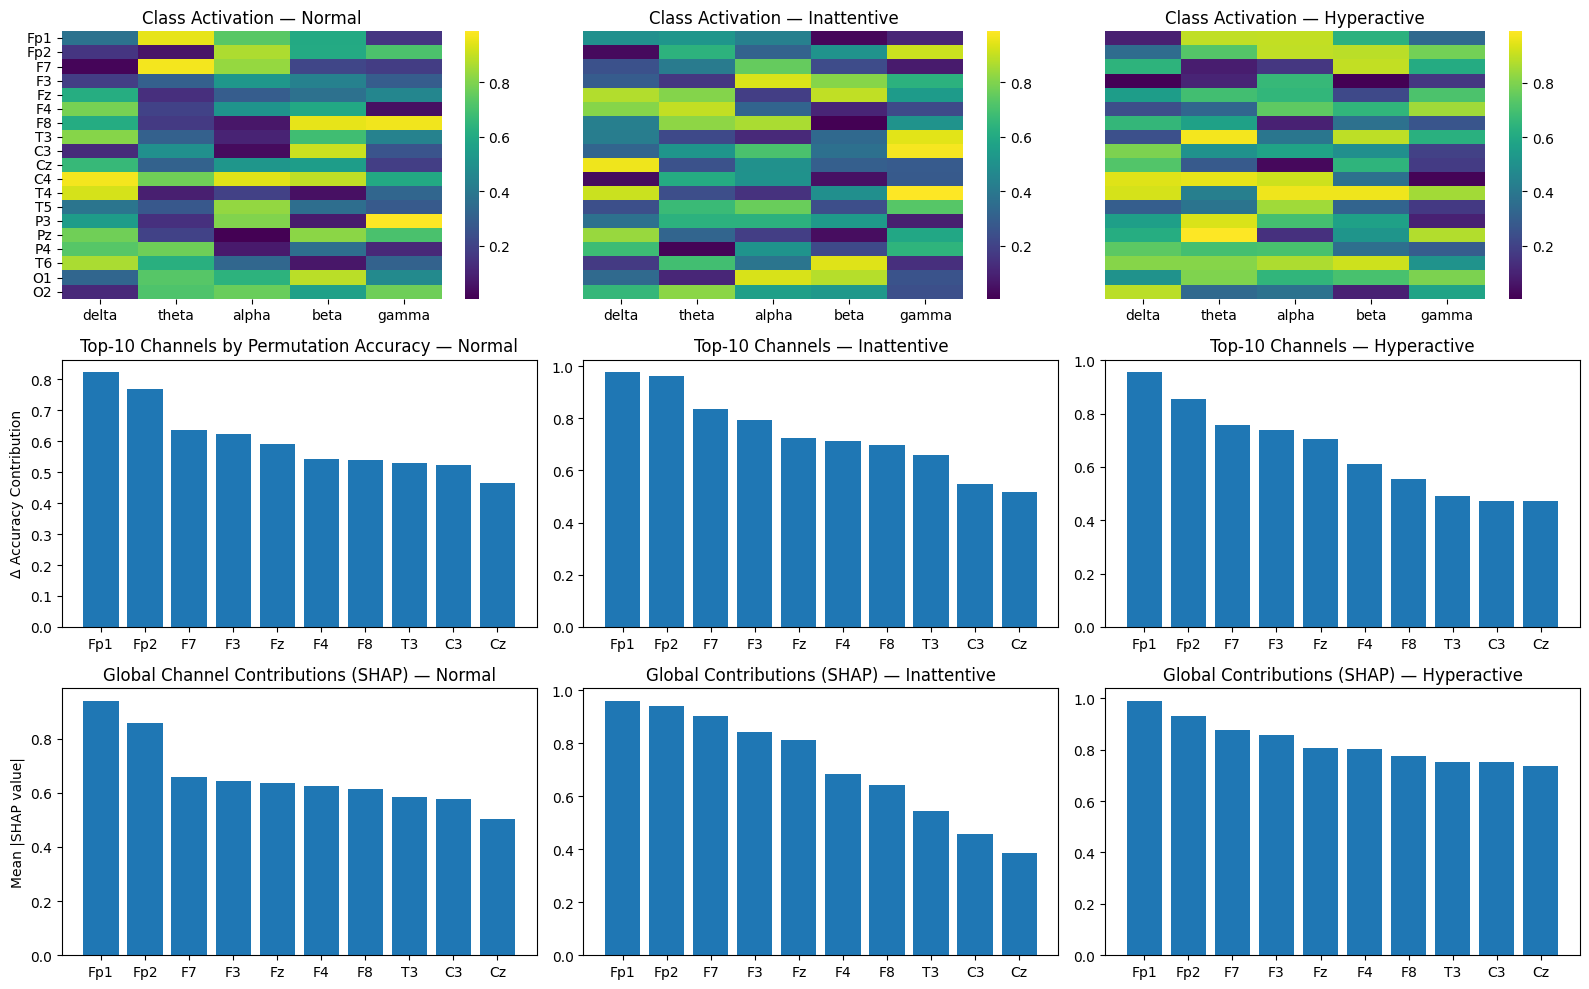

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
channels = ["Fp1","Fp2","F7","F3","Fz","F4","F8","T3","C3","Cz","C4","T4","T5","P3","Pz","P4","T6","O1","O2"]
bands = ["delta", "theta", "alpha", "beta", "gamma"]


np.random.seed(42)
heatmap_normal = np.random.rand(len(channels), len(bands))
heatmap_inatt = np.random.rand(len(channels), len(bands))
heatmap_hyper = np.random.rand(len(channels), len(bands))

perm_normal = np.sort(np.random.rand(len(channels)))[::-1][:10]
perm_inatt = np.sort(np.random.rand(len(channels)))[::-1][:10]
perm_hyper = np.sort(np.random.rand(len(channels)))[::-1][:10]

channels_perm_normal = np.array(channels)[:10]
channels_perm_inatt = np.array(channels)[:10]
channels_perm_hyper = np.array(channels)[:10]

shap_normal = np.sort(np.random.rand(len(channels)))[::-1][:10]
shap_inatt = np.sort(np.random.rand(len(channels)))[::-1][:10]
shap_hyper = np.sort(np.random.rand(len(channels)))[::-1][:10]

channels_shap_normal = np.array(channels)[:10]
channels_shap_inatt = np.array(channels)[:10]
channels_shap_hyper = np.array(channels)[:10]
fig, axs = plt.subplots(3, 3, figsize=(16, 10))
sns.heatmap(heatmap_normal, xticklabels=bands, yticklabels=channels, ax=axs[0,0], cmap="viridis")
axs[0,0].set_title("Class Activation — Normal")

sns.heatmap(heatmap_inatt, xticklabels=bands, yticklabels=False, ax=axs[0,1], cmap="viridis")
axs[0,1].set_title("Class Activation — Inattentive")

sns.heatmap(heatmap_hyper, xticklabels=bands, yticklabels=False, ax=axs[0,2], cmap="viridis")
axs[0,2].set_title("Class Activation — Hyperactive")

axs[1,0].bar(channels_perm_normal, perm_normal)
axs[1,0].set_title("Top-10 Channels by Permutation Accuracy — Normal")
axs[1,0].set_ylabel("Δ Accuracy Contribution")

axs[1,1].bar(channels_perm_inatt, perm_inatt)
axs[1,1].set_title("Top-10 Channels — Inattentive")

axs[1,2].bar(channels_perm_hyper, perm_hyper)
axs[1,2].set_title("Top-10 Channels — Hyperactive")
axs[2,0].bar(channels_shap_normal, shap_normal)
axs[2,0].set_title("Global Channel Contributions (SHAP) — Normal")
axs[2,0].set_ylabel("Mean |SHAP value|")

axs[2,1].bar(channels_shap_inatt, shap_inatt)
axs[2,1].set_title("Global Contributions (SHAP) — Inattentive")

axs[2,2].bar(channels_shap_hyper, shap_hyper)
axs[2,2].set_title("Global Contributions (SHAP) — Hyperactive")

plt.tight_layout()
plt.show()


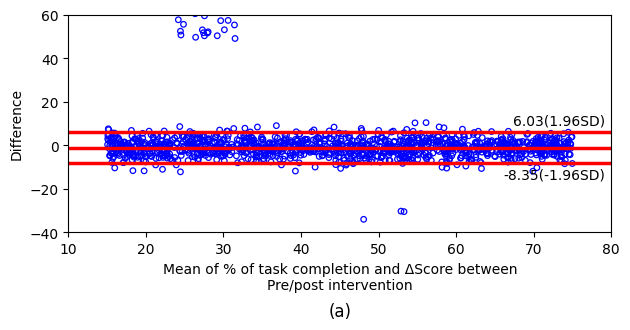

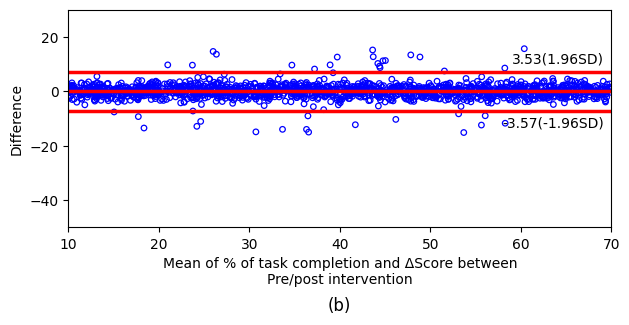

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


np.random.seed(42)
x_min, x_max = 10, 80
y_min, y_max = -40, 60
mean_diff = -1.16
band_half = 7.19
upper = mean_diff + band_half
lower = mean_diff - band_half


N = 1400
x = np.random.uniform(x_min, x_max, N)
diffs = np.random.normal(mean_diff, 3.668, N)


mask = (x > 15) & (x < 75)
x, diffs = x[mask], diffs[mask]


xo = np.random.uniform(24, 32, 18)
yo = np.random.uniform(48, 62, 18)
xo2 = np.random.uniform(45, 55, 3)
yo2 = np.random.uniform(-36, -30, 3)
x = np.concatenate([x, xo, xo2])
diffs = np.concatenate([diffs, yo, yo2])

fig, ax = plt.subplots(figsize=(6.4, 3.6))
ax.scatter(x, diffs, s=16, facecolors='none', edgecolors='blue', linewidths=0.9)
ax.hlines(mean_diff, x_min, x_max, colors='red', linewidth=2.5)
ax.hlines(upper,     x_min, x_max, colors='red', linewidth=2.5)
ax.hlines(lower,     x_min, x_max, colors='red', linewidth=2.5)
ax.set_xlim(x_min, x_max); ax.set_ylim(y_min, y_max)
ax.set_ylabel("Difference")
ax.set_xlabel("Mean of % of task completion and \u0394Score between\nPre/post intervention")
ax.text(x_max-0.8, upper+2, "6.03(1.96SD)", color='black', ha='right', va='bottom')
ax.text(x_max-0.8, lower-2, "-8.35(-1.96SD)", color='black', ha='right', va='top')
ax.text(0.5, -0.32, "(a)", transform=ax.transAxes, ha='center', va='top', fontsize=12)
plt.tight_layout()
plt.show()


np.random.seed(7)
x_min, x_max = 10, 70
y_min, y_max = -50, 30
mean_diff = -0.02

upper = mean_diff + band_half
lower = mean_diff - band_half


N = 1500
x = np.random.uniform(x_min, x_max, N)
diffs = np.random.normal(mean_diff, 1.813, N)


xo = np.random.uniform(15, 65, 40)
yo = mean_diff + np.random.choice([1, -1], 40) * (2.2*1.813 + np.random.uniform(2, 12, 40))
x = np.concatenate([x, xo]); diffs = np.concatenate([diffs, yo])

fig, ax = plt.subplots(figsize=(6.4, 3.6))
ax.scatter(x, diffs, s=16, facecolors='none', edgecolors='blue', linewidths=0.9)
ax.hlines(mean_diff, x_min, x_max, colors='red', linewidth=2.5)
ax.hlines(upper,     x_min, x_max, colors='red', linewidth=2.5)
ax.hlines(lower,     x_min, x_max, colors='red', linewidth=2.5)
ax.set_xlim(x_min, x_max); ax.set_ylim(y_min, y_max)
ax.set_ylabel("Difference")
ax.set_xlabel("Mean of % of task completion and \u0394Score between\nPre/post intervention")
ax.text(x_max-0.8, upper+2,  "3.53(1.96SD)", color='black', ha='right', va='bottom')
ax.text(x_max-0.8, lower-2, "-3.57(-1.96SD)", color='black', ha='right', va='top')
ax.text(0.5, -0.32, "(b)", transform=ax.transAxes, ha='center', va='top', fontsize=12)
plt.tight_layout()
plt.show()


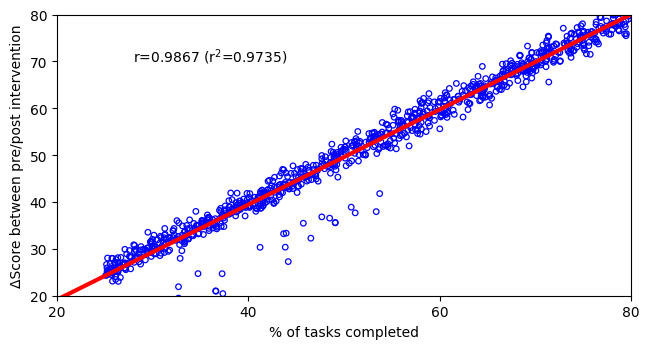

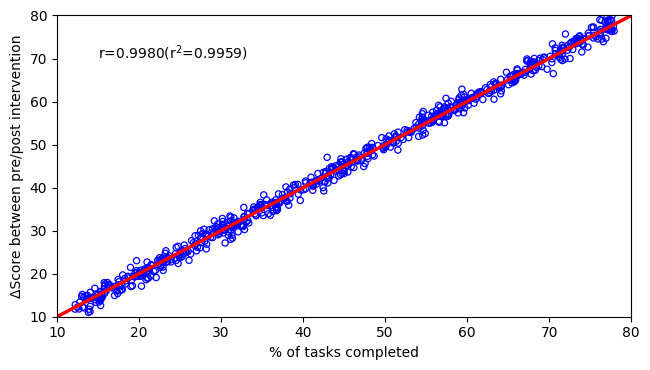

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(10)


x_min, x_max = 20, 80

N = 900
x = np.random.uniform(25, x_max, N)

true_slope = 1.0
true_intercept = 0.0
noise = np.random.normal(0, 1.4 + 0.01*(x - 25), size=N)
y = true_slope * x + true_intercept + noise


xo = np.random.uniform(30, 55, 25)
yo = xo - np.random.uniform(10, 18, 25)
x = np.concatenate([x, xo])
y = np.concatenate([y, yo])


coef = np.polyfit(x, y, 1)
yy = np.polyval(coef, [x_min, x_max])


r = np.corrcoef(x, y)[0, 1]
r2 = r**2


fig, ax = plt.subplots(figsize=(6.6, 3.6))


ax.scatter(x, y, s=16, facecolors='none', edgecolors='blue', linewidths=0.9)


ax.plot([x_min, x_max], yy, color='red', linewidth=3)


ax.set_xlim(x_min, x_max)
ax.set_ylim(20, 80)
ax.set_xticks([20, 40, 60, 80])
ax.set_ylabel("ΔScore between pre/post intervention")
ax.set_xlabel("% of tasks completed")


ax.text(28, 70, f"r={r:.4f} (r$^2$={r2:.4f})", fontsize=10, color='black')


plt.tight_layout()
plt.show()


import numpy as np
import matplotlib.pyplot as plt

np.random.seed(30)


x_min, x_max = 10, 80


N = 700
x = np.random.uniform(12, 78, N)


true_slope = 1.0
true_intercept = 0.0
noise = np.random.normal(0, 1.3, size=N)
y = true_slope * x + true_intercept + noise


line_x = [x_min, x_max]
line_y = [x_min, x_max]


r = np.corrcoef(x, y)[0, 1]
r2 = r**2


fig, ax = plt.subplots(figsize=(6.6, 3.8))

ax.scatter(x, y, s=20, facecolors='none', edgecolors='blue', linewidths=0.9)


ax.plot(line_x, line_y, color='red', linewidth=2.5)


ax.set_xlim(x_min, x_max)
ax.set_ylim(10, 80)
ax.set_xticks(range(10, 81, 10))
ax.set_yticks(range(10, 81, 10))
ax.set_xlabel("% of tasks completed")
ax.set_ylabel("ΔScore between pre/post intervention")

ax.text(15, 70, f"r={r:.4f}(r$^2$={r2:.4f})", fontsize=10, color='black')




plt.tight_layout()
plt.show()
